<a href="https://colab.research.google.com/github/lfernandof/neural-pop-dynamics/blob/main/projeto/exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Lavínia Mitiko Takarabe e Luís Fernando Fontoura

# Projeto final - Dinâmica de Populações Neuronais

Este projeto consiste na reimplementação das análises propostas no artigo "*An ensemble code in medial prefrontal cortex links prior events to outcomes during learning*" ([Humphries et al., 2018](https://www.nature.com/articles/s41467-018-04638-2)) como instrumento avaliativo na disciplina de Dinâmica de Populações Neuronais, no programa de pós-graduação em Neurociência e Cognição da Universidade Federal do ABC (UFABC).
***

### Definição do problema
No trabalho supracitado, os autores analisaram dados de atividade de disparo de potenciais de ação (*spiking*) registrados no córtex pré-frontal medial de ratos (n=4) ao longo de várias sessões. Os animais tinham de escolher, em um labirinto em Y, entre um dos braços de acordo com regras que variavam sequencialmente em cada sessão. A tarefa adotada era autoiniciada, com o animal partindo espontaneamente da região inicial do labirinto - antes da bifurcação -, e cada ensaio (*trial*) consistindo no registro entre o início do deslocamento e a chegada ao fim de um dos braços. O intervalo entre trials (daqui em diante *inter-trial interval*, ITI) consiste nos registros feitos entre o fim de cada trial e o retorno espontâneo do animal até o início do labirinto, incluindo o consumo do reforço (leite adoçado) nas trials corretas. Ao escolher o braço correto em dez trials consecutivas, a regra mudava sem nenhum alerta ou sinal e em sequência pré-estabelecida: escolher o braço à direita (egocêntrica), escolher o braço iluminado (alocêntrica), escolher o braço à esquerda (egocêntrica) e escolher o braço lúgubre (alocêntrica). Caso todas as regras fossem aprendidas, ou o animal se habituasse a uma decisão a despeito das regras - e.g. a decisão repetida pelo braço incorreto - a sessão era encerrada. Em 10 sessões, os animais apresentaram uma abrupta mudança de comportamento, com um aumento súbito nas recompensas acumuladas a partir de uma dada trial; essas sessões foram denominadas as sessões de aprendizado (*learning sessions*). Ao longo do experimento, cada animal aprendeu ao menos duas regras. Ao todo, foram feitos registros em 53 sessões, das quais 50 foram utilizadas para análise. Nesses registros as populações registradas variam entre 15-55 neurônios, com a atividade de spiking registrada a uma resolução temporal de 0.1ms.


Os autores almejavam ancorar o processo de aprendizagem de uma regra de maneira espontânea a um substrato de atividade neuronal. A maneira adotada foi analisar os spikes produzidos por uma população-chave (no texto *core population*) que estava ativa em todas as trials de cada sessão, a fim de encontrar similaridades entre as trials corretas e incorretas (sobretudo nas sessões de aprendizado). Para essa população-chave os trens de spikes foram convoluídos com um filtro gaussiano cuja resolução é $\sigma = 100ms$ e normalizados. A correlação entre a taxa normalizada de disparos de cada célula na população ao longo de cada trial foi ordenada em uma matriz chamada de *matriz de similaridade*. Por fim, os autores construíram uma matriz com as correlações entre as matrizes de similaridades para todas as células em cada par de trials, chamada de *matriz de recordação* (recall matrix). A matriz de recordação também foi calculada para trens de spikes cujos intervalos entre spikes (*inter-spike interval*, ISI) foram embaralhados, como um controle para a diferença nas durações entre trials em que o animal errou e acertou, que possuíam durações distintas. A subtração dessa matriz de controle da matriz de recordação legou-os uma matriz de recordação residual, cujas currelações entre cada tipo de trial (correta e incorreta) não são explicáveis pela diferença de duração, e portanto devem representar algo sobre a resposta à recompensa (nos dados das trials) e a *ensembles* associados à contingência experimental (nos dados dos ITIs).

#### Dados disponíveis

Os dados foram disponibilizados através da plataforma <a href="http://crcns.org/data-sets/pfc/pfc-6" target="_blank">CRCNS</a>, e o detalhamento sobre cada arquivo pode ser encontrado no arquivo \verb|crcns_pfc-6_data_description.pdf|. Em suma, foram utilizados neste trabalho os dados pertinentes à atividade de spiking durante cada sessão, `_SpikeData.dat`, e os dados pertinentes às características comportamentais da dessão `_Behavior.dat`.

Cada arquivo `_SpikeData.dat` possui duas colunas: o instante em que aconteceu cada disparo e a célula à qual ele pertence; cada linha é um spike. Nos arquivos `_Behavior.dat` constam seis colunas, respectivamente:

* o instante em que cada trial começa;
* o instante em que cada trial termina (chegada à região da entrega da recompensa);
* a regra pra reforço na trial;
* se o animal acertou ou errou na trial;
* o braço do labirinto que o animal adotou na trial;
* o braço iluminado na trial;

Cada linha neste arquivo corresponde a uma trial. Os demais arquivos não foram utilizados neste projeto.

#### Detalhamento da abordagem (pré-implementação)
A partir do texto exposto no artigo, construímos um fluxograma de trabalho que contempla cada etapa do processamento, partindo dos dados de cada sessão e chegando até a elaboração das figuras.

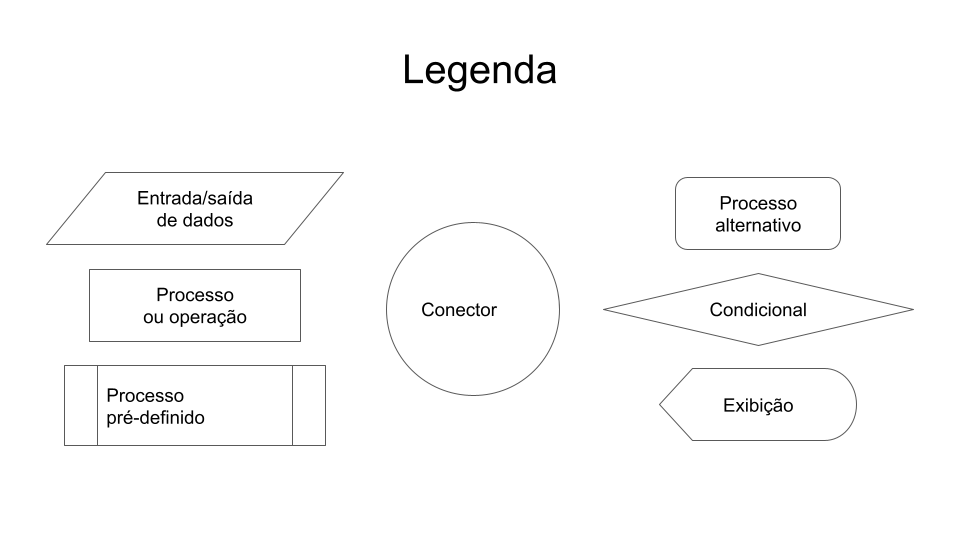

# Fluxograma do processo principal:
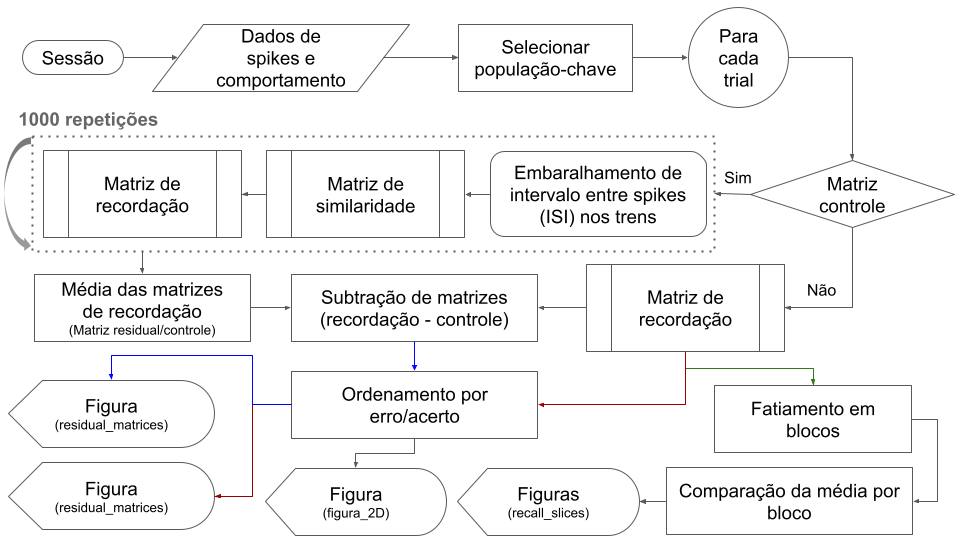

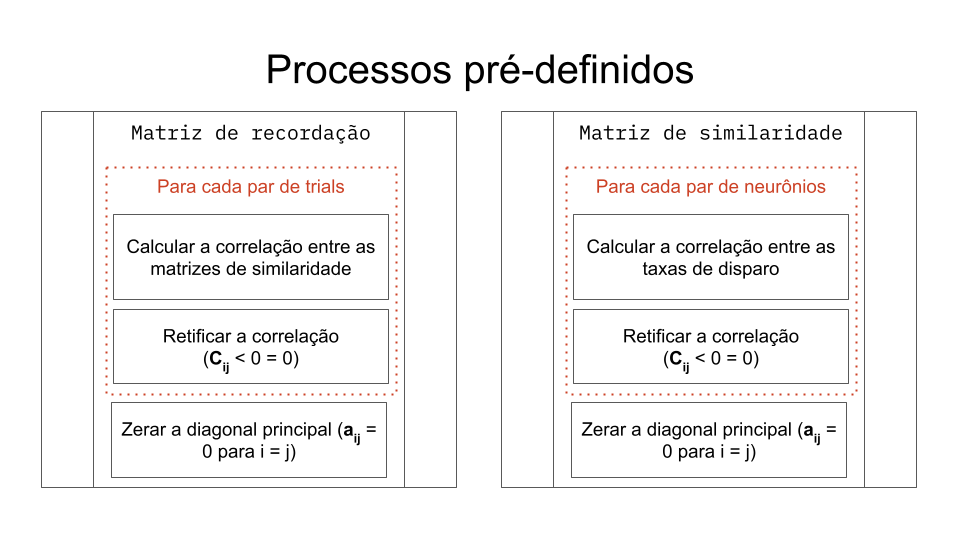

### Implementação

Segue abaixo a implementação de todas as funções, devidamente comentadas acerca do seu conteúdo e funcionamento. Além disso há uma rotina principal que integra todas elas em uma única chamada, e permite que uma única instrução gere todas as figuras pertinentes a uma sessão que é passada como argumento.

### Configuração do ambiente Colab
Permite o acesso do Google Colab ao drive, onde consta a pasta do projeto e seus subdiretórios, inclusive aquele no qual constam os dados.

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/projeto')

### Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal as sig
import random
import math
import itertools
import seaborn as sns

### Funções principais

In [ ]:
def load_data(session):
  '''Load behaviour data and spikes data for a given session.

  INPUT: session
  OUTPUT: a dataframe containing the behaviour data and a dataframe containing spike data
  '''
  behaviour_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/'+session+'/'+session+'_Behavior.dat',
                      header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python') #Behaviour.dat dataset
  spikes_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/'+session+'/'+session+'_SpikeData.dat',
                      header=None,names=['timestamp','cell'],engine = 'python') #SpikeData.dat dataset

  return behaviour_dataset, spikes_dataset

def time_conversion(dataset,column,conversion_factor=0.0001):
    '''Converts the timestamps in the dataset from 0.1 ms to seconds (0.001)'''
    dataset[column] = dataset[column]*conversion_factor
    return dataset

def number_of_trials(behaviour_dataset):
    '''Returns the number of trials for a given session.

    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: the number of trials
    '''
    return len(behaviour_dataset)

def trials_begin_end(behaviour_dataset):
    '''Returns the initial and final time for each trial.

    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: a list of tuples (trial_start,trial_end)
    '''
    n_trials = number_of_trials(behaviour_dataset)
    boundaries = []
    for trial in range(n_trials):
        lower_boundary = behaviour_dataset.iloc[trial].trial_start
        upper_boundary = behaviour_dataset.iloc[trial].trial_end
        boundaries.append((lower_boundary,upper_boundary))
    return boundaries

def ITIs_begin_end(behaviour_dataset):
  '''Returns the initial and final time for each intertime interval.

  INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
  OUTPUT: a list of tuples (trial_start,trial_end)
  '''
  n_ITIs = number_of_trials(behaviour_dataset)-1
  ITI_boundaries = []
  for ITI in range(n_ITIs):
    lower_boundary = behaviour_dataset.iloc[ITI].trial_end
    upper_boundary = behaviour_dataset.iloc[ITI+1].trial_start
    ITI_boundaries.append((lower_boundary,upper_boundary))

  return ITI_boundaries

def start_interval_from_zero(dataset):
    '''Subtracts the first timestamp value from all timestamps, so spike times begin from zero onward'''
    new_zero = dataset['timestamp'].min()
    dataset['timestamp'] = dataset['timestamp'].apply(lambda x: x - new_zero)
    return dataset

def spikes_in_interval(dataset,interval_start,interval_end):
    '''Returns all spikes in the dataset whose timestamps lay between the interval start and end boundaries

    INPUT: a Pandas DataFrame containing the spike data from the SpikeData.dat file of the corresponding session
    and the time boundaries that define the interval
    OUTPUT: a Pandas DataFrame containing the subset of spikes_dataset whose timestamps lie within the boundaries
    '''
    return dataset.loc[(dataset['timestamp'] >= interval_start) &
                       (dataset['timestamp'] <= interval_end)]

def separate_into_trials(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each trial in the session

    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each trial
    '''
    trials = []
    time_boundaries = trials_begin_end(behaviour_dataset)

    for trial in range(number_of_trials(behaviour_dataset)):
        trial_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][0],time_boundaries[trial][1])
        #trial_spikes = start_interval_from_zero(trial_spikes)
        trials.append(trial_spikes)

    return trials

def build_ITIs(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each ITI in the session

    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each ITI
    '''
    ITIs = []
    time_boundaries = trials_begin_end(behaviour_dataset)

    for trial in range(number_of_trials(behaviour_dataset)-1):
        ITI_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][1],time_boundaries[trial+1][0])
        ITI_spikes = start_interval_from_zero(ITI_spikes)
        ITIs.append(ITI_spikes)
    return ITIs

def delete_neurons(spikes_dataset,threshold = 3):
    '''Deletes neurons that spike less than three times in a trial

    INPUT: spikes DataFrame and a threshold [int] of the minimum number of spikes for the neuron to be considered
    OUTPUT: the same spikes_dataset structure (a Dataframe with two columns) but without the low-activity neurons
    '''

    neurons = spikes_dataset['cell'].unique()

    for neuron in neurons:
        #prevents neurons from less than threshold (in this case, 3) spikes from being further analysed
        if len(spikes_dataset.loc[spikes_dataset['cell'] == neuron]) > threshold:
            #print('there are ',len(spikes_dataset.loc[spikes_dataset['cell'] == neuron]),' spikes for neuron',neuron)
            continue
        else:
            spikes_dataset = spikes_dataset.drop(spikes_dataset[spikes_dataset['cell'] == neuron].index)
            #print('Discarded neuron:',neuron)
    return spikes_dataset

def neurons_in_all_trials(trials_dataset):
    '''Checks the global intersection in the sets of neurons that are active in each trial

    INPUT: A dataset that is spikes_data-like but split between trials, as returned by separate_into_trials()
    OUTPUT: A list of dataframes containing only the neurons that are active in each and every trial'''

    labels = []
    for trial in trials_dataset:
        labels.append(trial.cell.unique())

    sets = [set(label) for label in labels]
    test_set = sets.pop(0)

    for neurons in sets:
        test_set.intersection_update(neurons)

    neurons_trials = np.array(list(test_set))

    data = []

    for trial in trials_dataset:
      data.append(trial[trial['cell'].isin(neurons_trials)])

    return data

def gen_spiketrain_list(spikes_dataset):
    '''Splits the dataset into a list whose elements are the subsets comprising the spikes of each neuron

    INPUT: spikes DataFrame with two colums (timestamps for spikes and whose neuron it is)
    OUTPUT: a list whose elements are the subsets of the spikes Dataframe (with the same structure) for each neuron
    '''

    neurons = spikes_dataset['cell'].unique()
    spiketrain_list = []

    for neuron in neurons:
        split_dataset = spikes_dataset.loc[spikes_dataset['cell'] == neuron]
        spiketrain_list.append(split_dataset['timestamp'].to_numpy())

    return spiketrain_list

def spiketrains_per_trial(trials_dataset):
  '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each trial in the session

  INPUT: trials_dataset list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
  whose timestamps lie within the boundaries of each trial
  OUTPUT: a dictionary in which each key is associated with a trial and each element associate with this key is
  a list containing all the spike times of each neuron that spikes in all trials in this specific trial
  '''
  spiketrains = {}
  for i in range(len(trials_dataset)):
    trial = 'trial_' + str(i+1)
    spiketrains[trial] = gen_spiketrain_list(trials_dataset[i])

  return spiketrains

def kernel_convolve(spike_times, trial_start, trial_stop, bin_size=0.01,sigma = 1,n_sds = 5):
  '''Apply a gaussian convolution in a vector containing the spiketrains.

  INPUT: a NumPy array containing the spike times of one neuron in one trial, the initial and final time of the trial or the ITI,
  the bin size (in s), the resolution (sigma, undisclosed units from the paper hahahah because both s and ms screw it up) a
  nd the number of SDs that our kernel will span
  OUTPUT: a NumPy array with the convolved spike train
  '''

  sampling_timepoints = np.arange(start = -n_sds*sigma, stop = n_sds*sigma + 1, step = 1)
  resolution_constant = 2 * sigma**2
  normalisation_constant = 1/(np.sqrt(np.pi*resolution_constant))

  kernel = normalisation_constant * np.exp(-((sampling_timepoints**2)/resolution_constant))
  kernel = kernel/np.sum(kernel)

  #T = [min(spike_times),max(spike_times)]
  bins = np.arange(trial_start,trial_stop,bin_size)

  spk_histogram = np.histogram(spike_times,bins)

  convolution = np.convolve(kernel,spk_histogram[0])

  def firing_rate(convolution, bins):
    ''' Convert the convolved spiketrains into rate
    '''
    FR = convolution*(1/bins)
    return FR

  FR = firing_rate(convolution, bin_size)

  return convolution, FR

def convolve_spiketrains(spike_times, behaviour_dataset, label):
  ''' Generate a dictionary containing all the convolved spiketrains

  INPUT: the spike_times dictionary (see spiketrains_per_trial()), the behaviour_dataset and label {'trials' or 'ITIs'}
  OUTPUT: the convolved spike trains dictionary (see spiketrains_per_trial())
  '''
  convolved_spiketrains = {}
  #convolved_times = {}
  firing_rates = {}

  if label == 'ITIs':
    ITIs_intervals = ITIs_begin_end(behaviour_dataset)


  for i in range(len(spike_times)):
    trial = 'trial_' + str(i+1)

    if label=='trials':
      trial_start = behaviour_dataset['trial_start'][i]
      trial_end = behaviour_dataset['trial_end'][i]
    else:
      trial_start = 0
      trial_end = ITIs_intervals[i][1] - ITIs_intervals[i][0]


    convolved_spiketrain = []
    firing_rate = []

    for j in range(len(spike_times[trial])): # PODEMOS MEXER AQUI DEPOIS FIZ DO JEITO BURRO PQ DO OUTRO NÃO TAVA FUNCIONANDO

      spkt, FR = kernel_convolve(spike_times[trial][j],trial_start,trial_end)
      convolved_spiketrain.append(spkt)
      firing_rate.append(FR)


    convolved_spiketrains[trial] = convolved_spiketrain
    firing_rates[trial] = firing_rate

    #convolved_spiketrains[trial] =  list(map(kernel_convolve,spike_times[trial], [trial_start], [trial_end]))
    #convolved_times[trial] = list(map(kernel_times,spike_times[trial], [trial_start], [trial_end]))

  return convolved_spiketrains, firing_rates

def z_score(convolved_spiketrains):
  ''' Normalize the firing rates using z-score

  INPUT: the convolved spike trains dictionary (see spiketrains_per_trial())
  OUTPUT: the normalised (post-convolution) spike trains dictionary
  '''

  normalized_spiketrains = {}

  for i in range(len(convolved_spiketrains)):
    trial = 'trial_' + str(i+1)

    normal_spiketrain = []
    for j in range(len(convolved_spiketrains[trial])):
      normal_spiketrain.append((convolved_spiketrains[trial][j] - np.mean(convolved_spiketrains[trial], axis=0))/ np.std(convolved_spiketrains[trial]))

    normalized_spiketrains[trial] = normal_spiketrain

  return normalized_spiketrains

def similarity_matrix(normalized_spiketrains, retify=False):
  '''  Returns the similarity matrix in which each element is the correlation between a pair of valid neurons
  INPUT: spiketrains dictionary after gaussian convolution and normalization and a boolean indicating to apply or not the retification
  OUTPUT: a dictionary containing the similarity matrix for each trial
  '''
  similarity_matrices = {}

  for i in range(len(normalized_spiketrains)):
    trial = 'trial_' + str(i+1)

    if retify:
      similarity_matrices[trial] = np.corrcoef(normalized_spiketrains[trial])
      similarity_matrices[trial][similarity_matrices[trial]<0]=0
      similarity_matrices[trial][similarity_matrices[trial]==1]=0
    else:
      similarity_matrices[trial] = np.corrcoef(normalized_spiketrains[trial])

  return similarity_matrices

#NEW FUNCTION JUST DROPPED: A NOT-SO-EFFICIENT-YET-NOT-AS-CUMBERSOME WAY TO ESTIMATE THE RECALL MATRIX
def recall_matrix(similarity_matrices):
  '''
  Returns the rectified recall matrix

  INPUT: a dictionary containing the similarity matrix for all neurons in each trial (see similarity_matrix())
  OUTPUT: the recall matrix for all trials listed in this dictionary
  '''
  trials = len(similarity_matrices)
  R = np.zeros((trials,trials))

  for j in range(trials-1):
    #label "trial_N" for the first element in the pair
    trial1 = 'trial_'+str(j+1)
    for l in range(trials-1):
      #and for the second element
      trial2 = 'trial_'+str(l+1)

      #not even bother calculating the elements along the main diagonal:
      if j ==l:
        R[j,l] = 0
      else:
        #the correlation coefficient between these two trials is the off-diagonal correlation coefficient
        #which represents the correlation C_ij
        R[j,l] = np.corrcoef(similarity_matrices[trial1][:,1],similarity_matrices[trial2][:,1])[0,1]
  #rectify
  R[R<0] = 0

  return R

def isi_estimate(spike_times):
    '''Estimates the inter-spike interval (ISI) from a list of spike times (i.e. spikes_data['timestamp'])

    INPUT: A list of the instants in which spikes were fired
    OUTPUT: A list of inter-spike intervals for adjacent events'''

    isi = []
    for timestamp in range(len(spike_times)-1):
        current_isi = spike_times[timestamp+1] - spike_times[timestamp]
        isi.append(current_isi)
    return isi

def spike_train_shuffling(spike_times):
    '''
    Shuffles the inter-spike intervals (ISI) in a spike train. Indeed, this preserves the number of spikes,
    the total duration spanned by the spiking activity, the ISI distribution, and the mean rate. On the other hand,
    this annihilates any temporal structure in the spiking activity that could subserve some function.

    INPUT: a spike train, as given by a list of the timestamps of instants in which a spike occurs
    OUTPUT: another spike train with the same ISI distribution and number of spikes but shuffled spike positions'''

    #just in case it is passed as a DataFrame column and not a list
    spike_times = list(spike_times)

    #obtain the ISI
    isi_distribution = isi_estimate(spike_times)
    #and shuffle it
    random.shuffle(isi_distribution)

    '''since all spike trains are set to begin at t=0, setting the first spike to happen at t=0 is not a problem
    if this is not the case, select a random number - but beware this might make some spike trains longer'''
    current_spike = spike_times[0]

    new_spike_train = []

    for isi in isi_distribution:
        new_spike_train.append(current_spike)
        #the next spike will be positioned
        current_spike += isi

    return np.array(new_spike_train)

def predicted_recall(spikes_dataset,behaviour_dataset, label, number_of_shuffles=10):
  ''' Creates the matrix of shuffled spikes that will be subtracted from the recall matrix to build the residual matrix
  INPUT: a dataframe containing spike data and a dataframe containing the behaviour data (to get these dataframes use load_data() function)
        label argument is a string and  refers to the type of data to be analysed and should be either "trials" or "ITIs".
        number of shuffles refers to the number of recall matrices that will be generated using the shuffled spikes.
  OUTPUT: the average matrix generated using shuffled spikes.
  '''
  shufflings = []
  shuffled_recall_matrices = []

  for i in range(number_of_shuffles):
    current_recall = []
    shuffled_spikes = {trial: list(map(spike_train_shuffling,spikes_dataset[trial])) for trial in spikes_dataset.keys()}

    shufflings.append(shuffled_spikes)

    convolved_spiketrains_S, FR_trial_S = convolve_spiketrains(shuffled_spikes, behaviour_dataset, label)
    normalized_spiketrains_S = z_score(FR_trial_S)
    similarity_shuffled_matrices = similarity_matrix(normalized_spiketrains_S, retify=True)
    #and save this matrix as a sample of shuffled matrices
    current_recall = recall_matrix(similarity_shuffled_matrices)

    if np.isnan(current_recall).any():
      i = i -1
    else:
      shuffled_recall_matrices.append(current_recall)

  predicted_recall_matrix = np.mean(shuffled_recall_matrices,axis = 0)
  predicted_recall_matrix[predicted_recall_matrix<0]=0
  return predicted_recall_matrix


def reorder_R_by_reward(recall_matrix,behaviour_dataset, label):
  '''
  Reorders the recall matrix by trial outcome such that the correct and incorrect trials are segregated in blocks along the
  main diagonal (i.e. all correct vs. correct comparisons will be adjacent, and the same goes for incorrect vs. incorrect)

  INPUT: a recall matrix (trial vs. trial), the behaviour dataset, and whether it belongs to an ITI
  OUTPUT: this recall matrix reordered by correct and incorrect trials (or preceding trial, in case of ITI)
  '''
  if label == 'ITIs':
    ITI_indexer = behaviour_dataset.iloc[:-1 , :]
    ITI_aftercorr_ID = np.array(ITI_indexer.index[ITI_indexer['reward']==1])
    ITI_aftererr_ID = np.array(ITI_indexer.index[ITI_indexer['reward']==0])
    listing = np.concatenate((ITI_aftererr_ID, ITI_aftercorr_ID))
  else:
    correct_trials_ID = np.array(behaviour_dataset.index[behaviour_dataset['reward']==1])
    error_trials_ID = np.array(behaviour_dataset.index[behaviour_dataset['reward']==0])
    listing = np.concatenate((error_trials_ID,correct_trials_ID))

  R_matrix = recall_matrix
  R_matrix = R_matrix[:,listing]
  R_matrix = R_matrix[listing,:]

  return R_matrix

def segment_recall_matrix(recall_matrix,threshold,concat=False):
  '''
  INPUT: the recall matrix R and the threshold between the two segments (e.g. the # of incorrect trials, or an arbitrary trial/ITI)
  OUTPUT: two square submatrices of R: the recall in the trials/ITIs before the threshold and the ones after the threshold

  (See the blocks in Figure 2C to get an idea of what example thresholds are, and which matrices it'll output)
  '''
  below_threshold = recall_matrix[:threshold, :threshold]
  above_threshold = recall_matrix[threshold:, threshold:]

  if concat:
    below_threshold = np.concatenate(below_threshold)
    above_threshold = np.concatenate(above_threshold)

  return below_threshold,above_threshold

def recall_slicing(recall_matrix,padding = 5,num_segments = 6,residual_tag=False):
  '''
  This (rather big) function does a lot pertaining the figure 4 (and 2, somewhat; see below).

  First it counts the number of trials, and estimates how many trials we can fit per segment in order to yield
  N slicings (N being num_segments) after discounting the padding, which saves a few trials so our smaller matrices
  can at least be comparable to the bigger ones.

  It then slices the recall matrix a num_segments of times, and returns two submatrices each time: one whose trials
  fall below the threshold (section) in that slicing and other comprising the trials that stay above this cutoff.

  Next, the average recall is estimated for both matrices, and they are input to a DataFrame consisting of three columns:
  'average','section', and 'class'. The first is the average value for the corresponding matrix, whether its trials fall
  below or above the section (class), and the section that sliced the recall matrix to yield it.

  Finally, it produces a grayscale vector with num_segments colour values used to plot the corresponding segments on top
  of the heatmap.

  NOTE: If padding = num_error_trials and num_segments = 1, this function yields the separation between correct
  and incorrect trials seen in figure 2C
  '''

  if padding > len(recall_matrix[0]):
    raise Exception('padding maior que o número de trials')

  segment_width = np.floor((len(recall_matrix[0])-2*padding)/num_segments)
  sections = []
  #add a segment each segment after another, the first starting at the padding
  current_segment = padding/2+segment_width

  for _ in range(num_segments):
    sections.append(int(current_segment))
    current_segment+=segment_width

  data = []
  for section in sections:
    recall_below,recall_above = segment_recall_matrix(recall_matrix,section,concat = False)
    averages = [np.mean(recall_below),np.mean(recall_above)]
    data.append((averages[0],section,'below',residual_tag))
    data.append((averages[1],section,'above',residual_tag))

  if residual_tag:
    df = pd.DataFrame(data,columns=['Average recall','Threshold','Class','Residual'])
  else:
    df = pd.DataFrame(data,columns=['Average recall','Threshold','Class','Residual'])

  grayscale = []

  colour = 1

  for _ in sections:
    grayscale.append(str(colour))
    colour -=1/len(sections)
  return df,sections,grayscale

#############################
### PLOT AND SAVE FIGURES ###
#############################

def gen_similarity_matrix_plots(similarity_matrices, label, session, dir, save_fig = False):
  ''' Generate the similarity matrix plot (comparable to Fig. 1A)
  INPUT: a dictionary containing the similarity matrices of trials an dindexed by trials,
  label argument is a string and  refers to the type of data to be analysed and should be either "trials" or "ITIs",
  to save figures in the right paths you also need to provide the session number, the directory and a boolean indicating to save the figure
  '''
  similarity_matrix = similarity_matrices[label]
  for trial in similarity_matrix:
    plt.figure()
    g = sns.heatmap(similarity_matrix[trial], cmap='Greys', vmax=0.5)
    if save_fig:
      path = dir + '/figures/similarity_matrices/' + label + '/' + session + '_' + trial + '.png'
      fig = g.get_figure()
      fig.savefig(path)

def gen_recall_matrix_plot(recall_matrices, label, session, dir, save_fig = False):
  ''' Generate the recall matrix plot (comparable to Fig. 1C-left)
  INPUT: a dictionary containing the recall matrices of trials and ITIs,
  label argument is a string and  refers to the type of data to be analysed and should be either "trials" or "ITIs",
  to save figures in the right path you also need to provide the session number, the directory and a boolean indicating to save the figure
  '''
  recall_matrix = recall_matrices[label]

  plt.figure()
  g = sns.heatmap(recall_matrix, cmap='coolwarm')
  if save_fig:
    path = dir + '/figures/recall_matrices/' + label + '/' + session + '.png'
    fig = g.get_figure()
    fig.savefig(path)

def gen_residual_matrix_plot(residual_matrices, label, session, dir, save_fig = False):
  ''' Generate the residual matrix plot (comparable to Fig. 1C-right)
  INPUT: a dictionary containing the recall matrices of trials and ITIs,
  label argument is a string and  refers to the type of data to be analysed and should be either "trials" or "ITIs",
  to save figures in the right path you also need to provide the session number, the directory and a boolean indicating to save the figure
  '''
  residual_matrix = residual_matrices[label]

  plt.figure()
  g = sns.heatmap(residual_matrix, cmap='coolwarm')
  if save_fig:
    path = dir + '/figures/residual_matrices/' + label + '/' + session + '.png'
    fig = g.get_figure()
    fig.savefig(path)


def plot_2D(recall_matrices, residual_matrices, behaviour_dataset, label, session, dir, save_fig=False):
  ''' Comparison of ensemble activity between trials or inter-trial intervals (comparable to Fig. 2D)
  INPUT: recall matrices dictionary, residual matrices dictionary, behaviour dataset, label argument (should be either "trials" or "ITIs"),
  to save figures in the right path you also need to provide the session number, the directory and a boolean indicating to save the figure
  '''
  len_errors = gen_len_errors(label, behaviour_dataset)
  error_recall_matrix = recall_matrices[label][:len_errors,:len_errors]
  error_residual_matrix = residual_matrices[label][:len_errors,:len_errors]

  correct_recall_matrix = recall_matrices[label][len_errors:,len_errors:]
  correct_residual_matrix = residual_matrices[label][len_errors:,len_errors:]

  original = [np.mean(error_recall_matrix), np.mean(correct_recall_matrix)]
  residual = [np.mean(error_residual_matrix), np.mean(correct_residual_matrix)]

  plt.figure(figsize=(5,8))
  plt.plot(original, marker='o', markersize=20, color='k', label='original')
  plt.plot(residual, marker='o', markersize=20, color='grey', label='residual')
  plt.xlabel(['Error', 'Correct'])
  plt.legend()

  if save_fig:
    path = dir + '/figures/Fig2D/' + label + '/' + session + '.png'
    plt.savefig(path)

def plot_recall_PDFs(recall_matrices, behaviour_dataset, label, session, dir, save_fig=False, residual = False):
  ''' Comparison between the probability density functions of the recall and residual matrices
  in correct and incorrect trials (comparable to the bottom panels in Fig. 2C)

  INPUT: recall matrices dictionary, behaviour dataset, label argument (should be either "trials" or "ITIs"), to save figures
  in the right path you also need to provide the session number, the directory and a boolean indicating to save the figure
  OUTPUT: a plot of the probability density function for the recall values in error and correct trials, as in fig. 2C
  '''
  len_errors = gen_len_errors(label, behaviour_dataset)

  if residual:
    matrix_type = 'residual'
  else:
    matrix_type = 'recall'

  #turn the matrices into a column vector ALAKAZAM
  errors_vector,correct_vector = segment_recall_matrix(recall_matrices[label],len_errors,concat=True)

  def center_histogram_two_pops(error_vector,correct_vector,bins=30):
    '''
    Estimate histograms according to the desired binning and return the bin centers, not the edges (as np.histogram() would)
    '''
    #bins = 30 because they used this... no special reason beyond that
    hist_err, bins = np.histogram(errors_vector, bins=bins)
    hist_corr, bins = np.histogram(correct_vector, bins=bins)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2
    return hist_err,hist_corr,center,width

  #histograms
  hist_err,hist_corr,center,width = center_histogram_two_pops(errors_vector,correct_vector,bins=30)

  plt.figure()
  plt.bar(center, hist_err/np.sum(hist_err), align='center', width=width, color='grey',alpha = 0.3)
  plt.bar(center, hist_corr/np.sum(hist_corr), align='center', width=width, color='red',alpha = 0.3)
  plt.xlabel('Recall')
  plt.ylabel('Probability density function')

  if save_fig:
    path = dir + '/figures/PDFs/' + label + '/' + session + '_' + matrix_type + '.png'
    plt.savefig(path)

def gen_recall_slices_plot(residual_matrices, label, session, dir, save_fig = False,padding = 5,num_segments = 6):
  '''
  Plots the residual recall matrix overlaid with grey lines corresponding to each subset of trials/ITIs used to divide the
  session into subsets (Figure 4A in the paper). Check recall_slicing() for more information.

  INPUT: residual_matrices dictionary, label (either 'trials' or 'ITIs'), the padding (minimum number of trials in a block)
  and the number of segments (how many thresholdings to use in order to divide the residual matrix into blocks)
  OUTPUT: a heatmap plot of the residual recall matrix with an overlaid grid of num_segments lines coloured in a grayscale
  from white (first slicing of the recall matrix)  to black (last slicing of the recall matrix) that divide it into blocks.
  '''
  residual_matrix = residual_matrices[label]
  averages_res,sections,grayscale = recall_slicing(residual_matrix,padding,num_segments)

  plt.figure()
  g = sns.heatmap(residual_matrix, cmap='coolwarm',square=True)

  for i in range(len(sections)):
    g.hlines(sections[i], *g.get_xlim(),colors=grayscale[i],lw=3)
    g.vlines(sections[i], *g.get_ylim(),colors=grayscale[i],lw=3)

  plt.figure()
  h = sns.pointplot(x='Class',y='Average recall',data=averages_res,hue='Threshold')

  if save_fig:
    path1 = dir + '/figures/recall_slices/' + label + '/' + session + '_' + 'blocks'+ '.png'
    fig1 = g.get_figure()
    fig1.savefig(path1)

    path2 = dir + '/figures/recall_slices/' + label + '/' + session + '_' + 'block_averages'+ '.png'
    fig2 = h.get_figure()
    fig2.savefig(path2)

def gen_spiketrains_heatmap(firing_rate, label, session=None, dir = None, save_fig=False):
  ''' Generate the spiketrains heatmap (comparable to Fig. 1B)
  INPUT: a dictionary containing the normalized firing rates of trials and ITIs indexed by trials,
  label argument is a string and  refers to the type of data to be analysed and should be either "trials" or "ITIs",
  to save figures in the right paths you also need to provide the session number, the directory and a boolean indicating to save the figure
  '''
  FR = firing_rate[label]
  for trial in FR:
    normalized_arr = normalize(FR[trial])
    plt.figure()
    g = sns.heatmap(normalized_arr, cmap = 'Greys');
    #xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()/10];
    #g.set_xticklabels(xlabels);
    if save_fig:
      path = dir + '/figures/FR_heatmap/' + label + '/' + session + '_' + trial + '.png'
      fig = g.get_figure()
      fig.savefig(path)

###################
#### UTILITIES ####
###################

def gen_len_errors(label, behaviour_dataset, session=None):
  ''' Compute the number of incorrect trials. It is useful to split ordered matrix between correct and incorrect trials
  INPUT: label (should be either "trials" or "ITIs") and behaviour dataset
  '''
  listing = []

  if label == 'trials':
    error_trials_ID = np.array(behaviour_dataset.index[behaviour_dataset['reward']==0])
    len_error = len(error_trials_ID)

  else:
    ITI_indexer = behaviour_dataset.iloc[:-1 , :]
    ITI_aftererr_ID = np.array(ITI_indexer.index[ITI_indexer['reward']==0])
    len_error = len(ITI_aftererr_ID)

  return len_error

def normalize(data):
  ''' Normalize data between 0 and 1
  '''
  return (data - np.min(data)) / (np.max(data)- np.min(data))

### Função que instancia a geração de figuras

In [ ]:
def plot_and_save(behaviour_dataset, firing_rates, similarity_matrices, recall_matrices, residual_matrices, session, dir=None, save_figs=False):
  ''' This function plot all the above mentioned figures and save them into files if save_figs=True
  '''
  # TRIALS
  gen_spiketrains_heatmap(firing_rates, 'trials', session, dir, save_figs)
  gen_similarity_matrix_plots(similarity_matrices, 'trials', session, dir, save_figs)
  gen_recall_matrix_plot(recall_matrices, 'trials', session, dir, save_figs)
  gen_residual_matrix_plot(residual_matrices, 'trials', session, dir, save_figs)
  gen_recall_slices_plot(residual_matrices,'trials',session,dir,save_figs,padding=5,num_segments=6)
  plot_2D(recall_matrices, residual_matrices, behaviour_dataset, 'trials', session, save_figs)
  plot_recall_PDFs(recall_matrices, behaviour_dataset,  'trials', session, dir,save_figs)
  plot_recall_PDFs(residual_matrices, behaviour_dataset,  'trials', session, dir,save_figs, residual = True)

  # ITIs
  gen_spiketrains_heatmap(firing_rates, 'ITIs', session, dir, save_figs)
  gen_similarity_matrix_plots(similarity_matrices, 'ITIs', session, dir, save_figs)
  gen_recall_matrix_plot(recall_matrices, 'ITIs', session, dir, save_figs)
  gen_residual_matrix_plot(residual_matrices, 'ITIs', session, dir, save_figs)
  gen_recall_slices_plot(residual_matrices,'ITIs',session,dir,save_figs,padding=5,num_segments=6)
  plot_2D(recall_matrices, residual_matrices, behaviour_dataset, 'ITIs', session, save_figs)
  plot_recall_PDFs(recall_matrices, behaviour_dataset, 'ITIs', session, dir,save_figs)
  plot_recall_PDFs(residual_matrices, behaviour_dataset, 'ITIs', session, dir,save_figs, residual = True)

### Rotina principal
Concatena todas as etapas da análise em uma única chamada e constrói todos os diretórios, figuras e demais resultados pertinentes a uma sessão.

In [ ]:
def run_session_analysis(session, number_of_shuffles=1000, dir = None, save_figs=False):
  ''' Run all the analysis for a given session, if a dir is passed it will plot the figures and if save_figs=True it will also save them in the givem directory
  '''

  ######################
  #### LOADING DATA ####
  ######################

  #load data
  behaviour_dataset, spikes_dataset = load_data(session)

  ########################
  #### PRE-PROCESSING ####
  ########################

  #adjust times from ms to s
  spikes_dataset = time_conversion(spikes_dataset,'timestamp') #timestamps now in seconds
  behaviour_dataset = time_conversion(behaviour_dataset,'trial_start') #trial_start now in seconds
  behaviour_dataset = time_conversion(behaviour_dataset,'trial_end') #trial_end now in seconds

  #number of trials and their time boundaries
  n_trials = number_of_trials(behaviour_dataset)
  trial_intervals = trials_begin_end(behaviour_dataset)

  #estimate ITI's interval
  ITIs_intervals = ITIs_begin_end(behaviour_dataset)

  #split the spikes_dataset into separate trials and ITIs
  trials = separate_into_trials(behaviour_dataset,spikes_dataset)
  ITIs = build_ITIs(behaviour_dataset,spikes_dataset)

  #drop neurons that spike less than three times in a trial/ITI
  trials = list(map(delete_neurons,trials))
  ITIs = list(map(delete_neurons,ITIs))

  #find the intersection of neurons that are active at every trial/ITI
  dfs_neurons_trials = neurons_in_all_trials(trials)
  dfs_neurons_ITIs = neurons_in_all_trials(ITIs)

  #generate the list of spiketimes per trial
  spiketime_list = spiketrains_per_trial(dfs_neurons_trials)
  ITIstime_list = spiketrains_per_trial(dfs_neurons_ITIs)


  ####################
  #### PROCESSING ####
  ####################

  #calculate the estimated firing rate
  convolved_spiketrains, FR_trial = convolve_spiketrains(spiketime_list, behaviour_dataset, label='trials')
  convolved_ITIs, FR_ITIs = convolve_spiketrains(ITIstime_list, behaviour_dataset, label='ITIs')

  #normalize the firing rates
  normalized_spiketrains = z_score(FR_trial)
  normalized_ITIs = z_score(FR_ITIs)

  firing_rates = {}

  firing_rates['trials'] = normalized_spiketrains
  firing_rates['ITIs'] = normalized_ITIs

  #calculate the similarity matrices
  similarity_matrices = {}

  similarity_trials_matrices = similarity_matrix(normalized_spiketrains, retify=True)
  similarity_ITIs_matrices = similarity_matrix(normalized_ITIs, retify=True)

  similarity_matrices['trials'] = similarity_trials_matrices
  similarity_matrices['ITIs'] = similarity_ITIs_matrices

  #compute the recall matrix and the residual matrix
  recall_matrices = {}
  residual_matrices = {}

  trials_R = recall_matrix(similarity_trials_matrices)
  trials_predicted_R = predicted_recall(spiketime_list,behaviour_dataset, label = 'trials', number_of_shuffles = number_of_shuffles)
  trials_residual = trials_R - trials_predicted_R
  ordered_trials_recall = reorder_R_by_reward(trials_R,behaviour_dataset, label='trials')
  ordered_trials_residual = reorder_R_by_reward(trials_residual,behaviour_dataset, label='trials')

  ITIs_R = recall_matrix(similarity_ITIs_matrices)
  ITIs_predicted_R = predicted_recall(ITIstime_list, behaviour_dataset, label = 'ITIs',number_of_shuffles = number_of_shuffles)
  ITIs_residual = ITIs_R - ITIs_predicted_R
  ordered_ITIs_recall = reorder_R_by_reward(ITIs_R,behaviour_dataset, label='ITIs')
  ordered_ITIs_residual = reorder_R_by_reward(ITIs_residual,behaviour_dataset, label='ITIs')

  recall_matrices['trials'] = ordered_trials_recall
  residual_matrices['trials'] = ordered_trials_residual


  recall_matrices['ITIs'] = ordered_ITIs_recall
  residual_matrices['ITIs'] = ordered_ITIs_residual
  if dir != None:
    plot_and_save(behaviour_dataset, firing_rates, similarity_matrices, recall_matrices, residual_matrices, session, dir, save_figs)

  return behaviour_dataset, firing_rates, similarity_matrices, recall_matrices, residual_matrices

### Load data

In [ ]:
#Fetch (in order) the session/trial pair in which learning occurred
learning_trial_number = [23,23,14,5,10,12,5,18,11,8]
analyse_trial_session = ['201222','201227','201229','181012','181020',
                            '150628','150630','150707','190214','190228']

#Zip these two lists so the elements will be paired into tuples (session,trial)
learning_events = zip(analyse_trial_session,learning_trial_number)

### Plot and save the generated figures

In [ ]:
dir = '/content/drive/MyDrive/projeto'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:647: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/loc

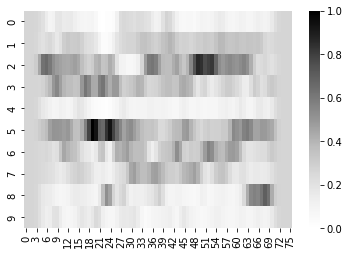

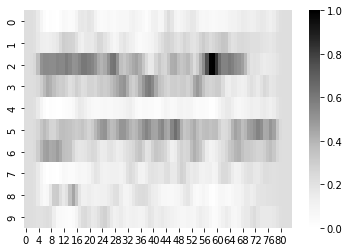

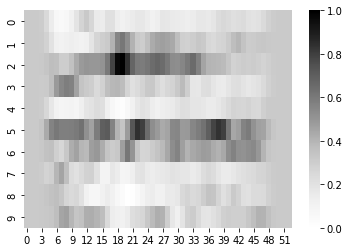

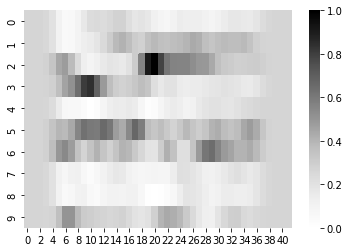

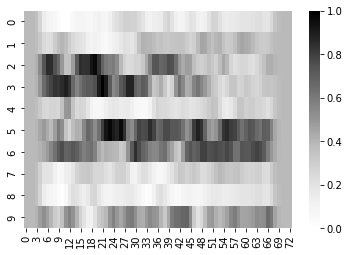

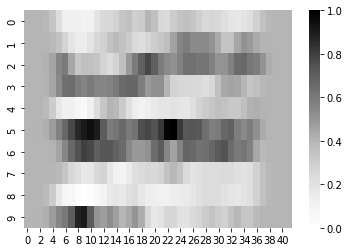

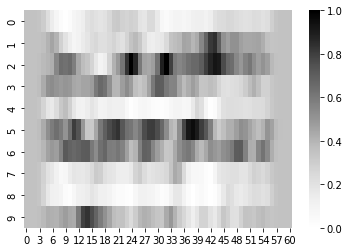

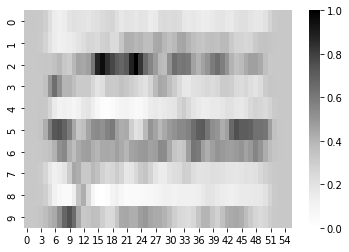

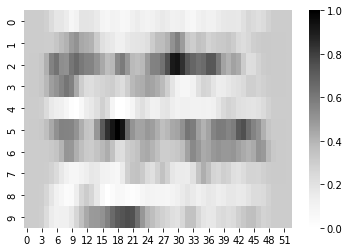

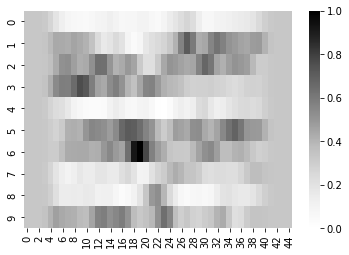

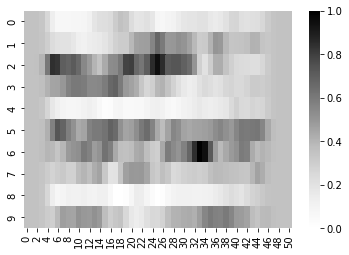

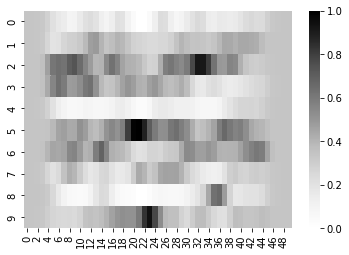

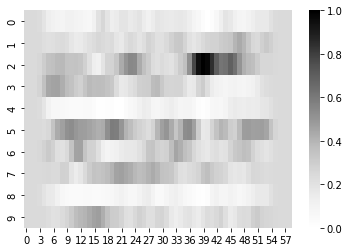

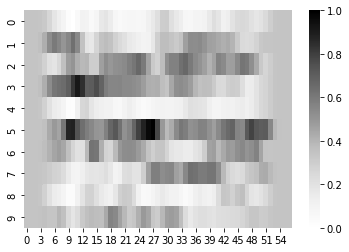

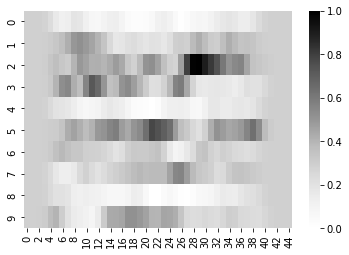

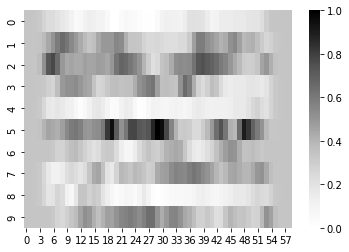

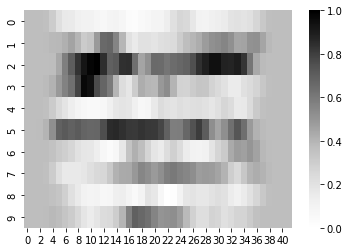

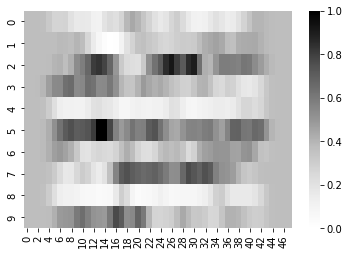

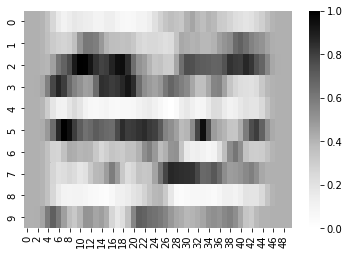

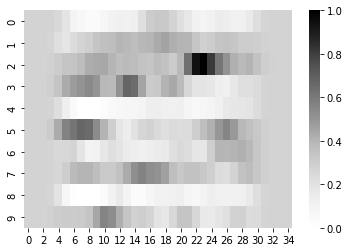

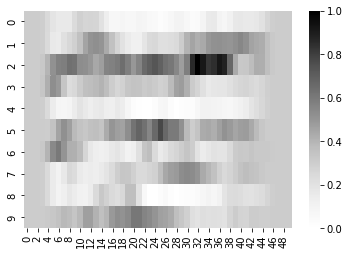

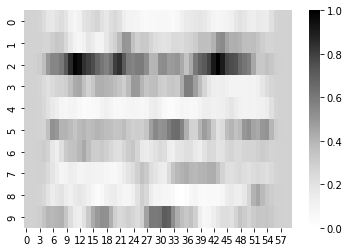

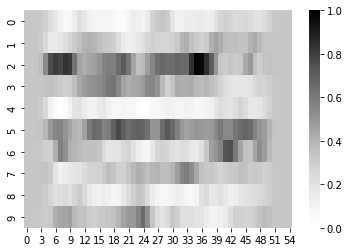

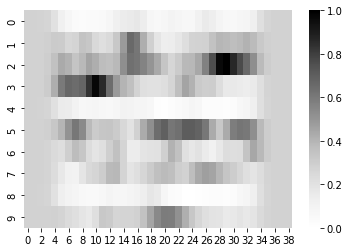

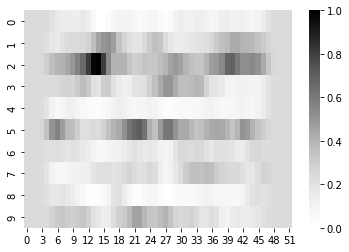

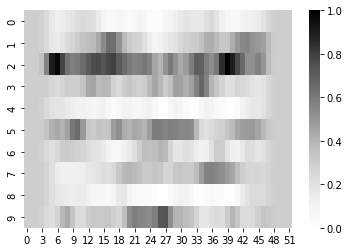

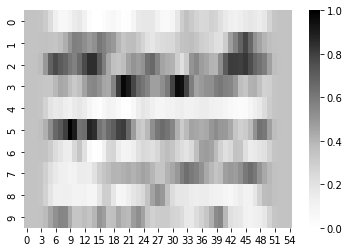

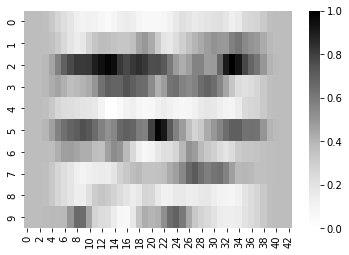

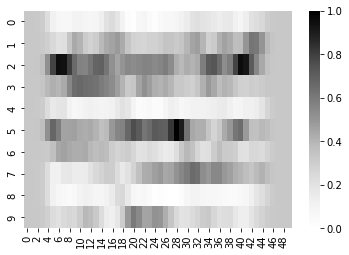

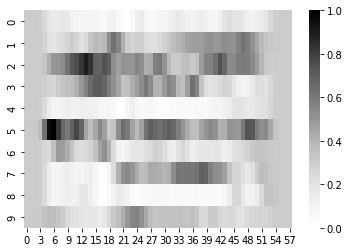

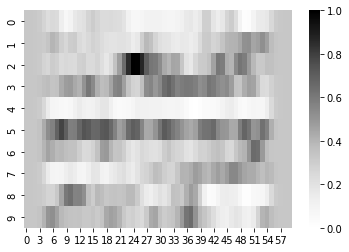

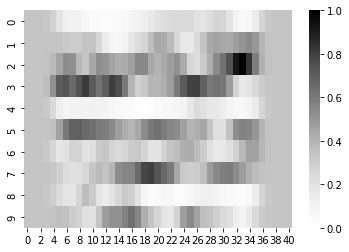

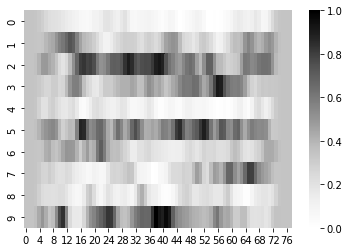

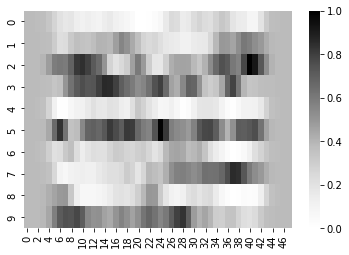

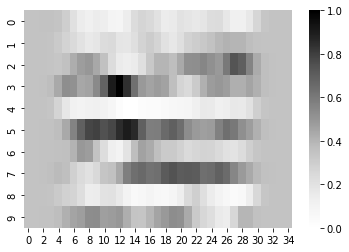

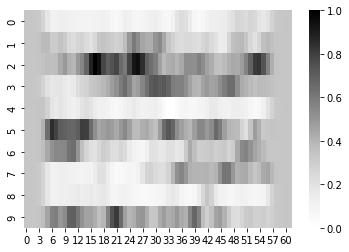

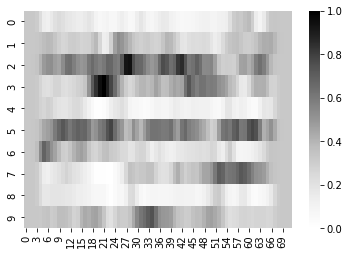

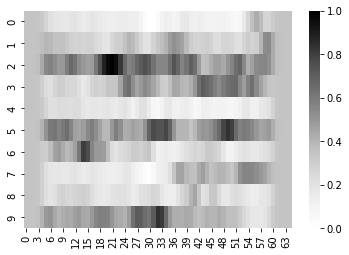

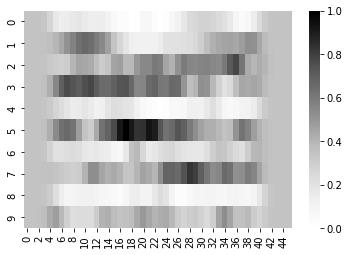

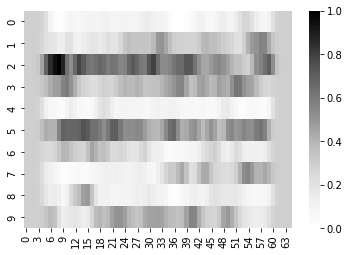

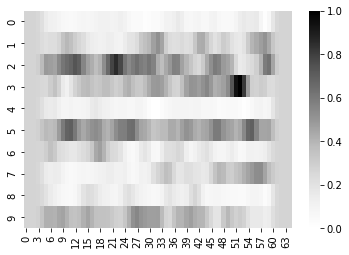

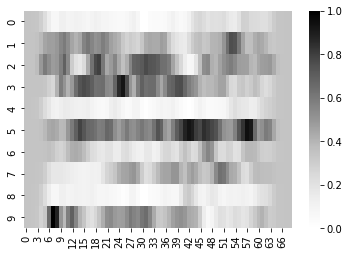

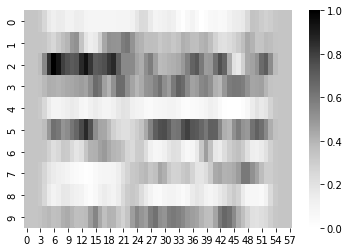

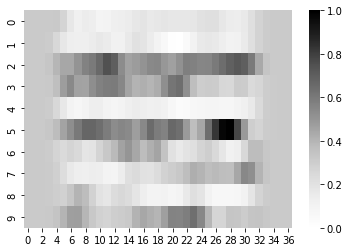

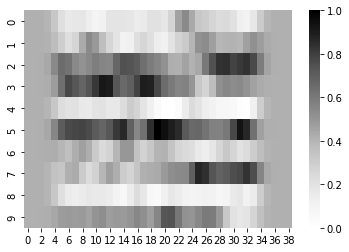

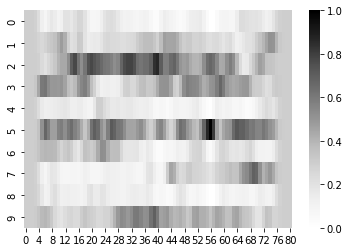

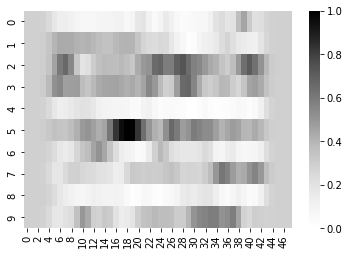

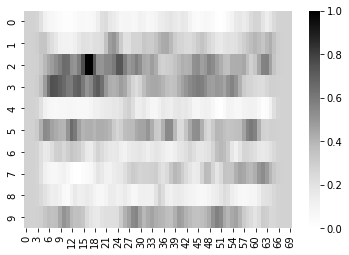

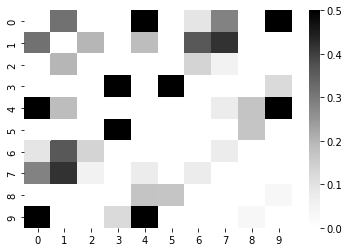

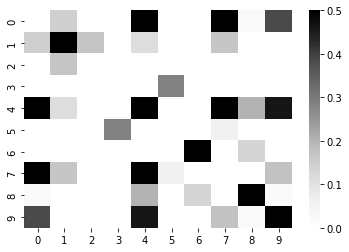

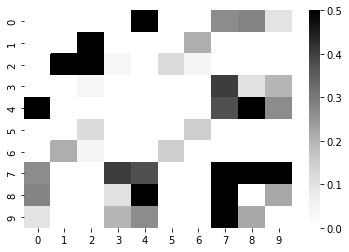

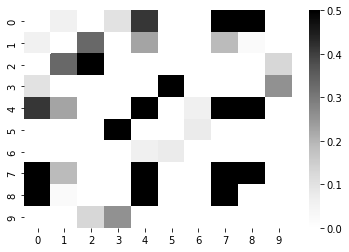

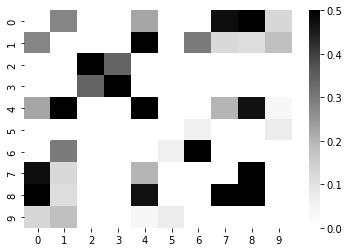

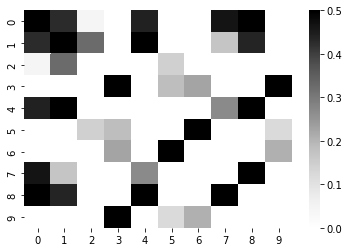

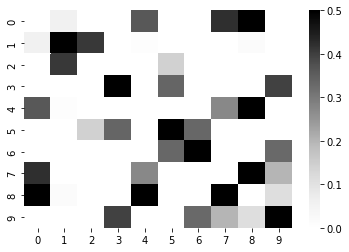

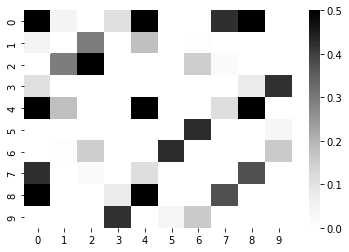

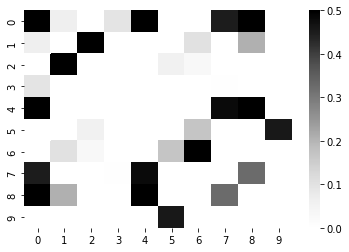

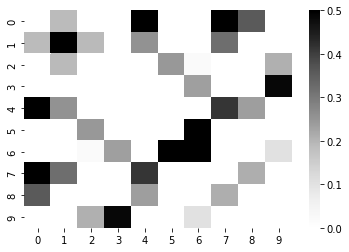

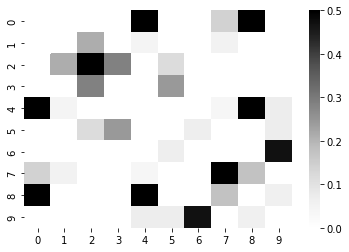

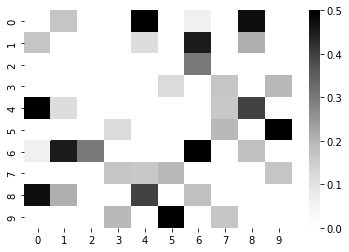

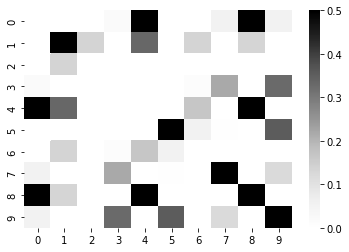

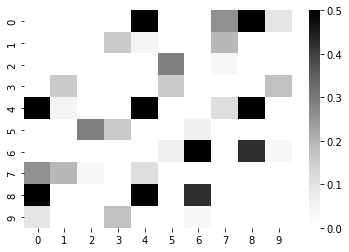

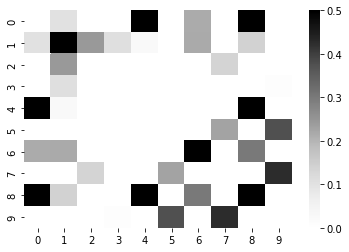

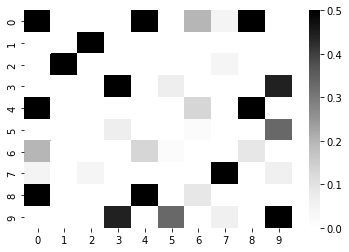

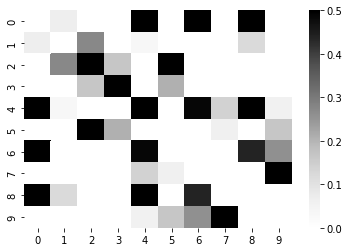

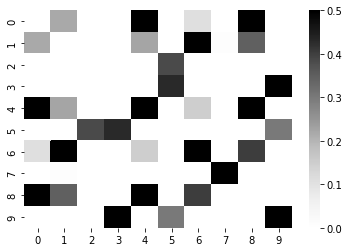

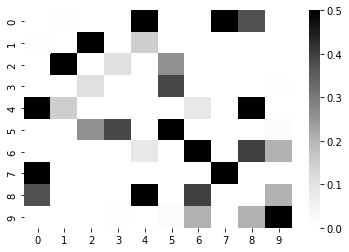

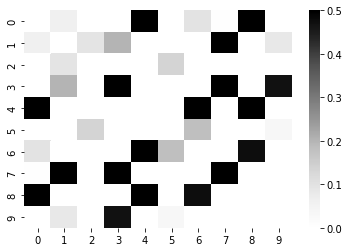

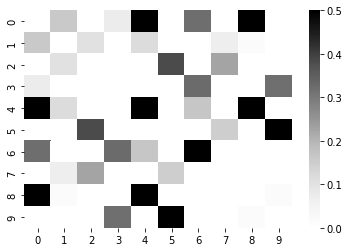

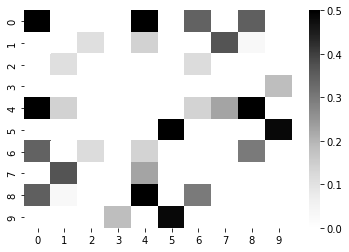

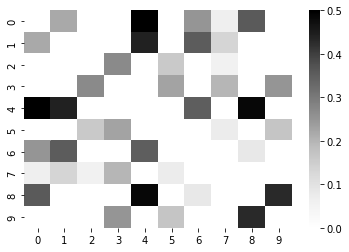

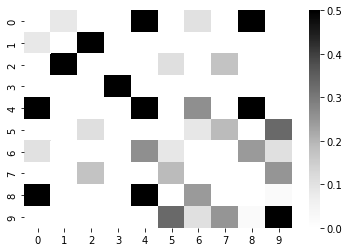

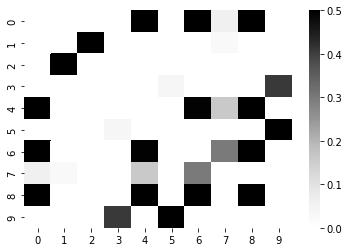

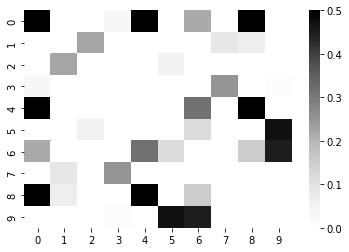

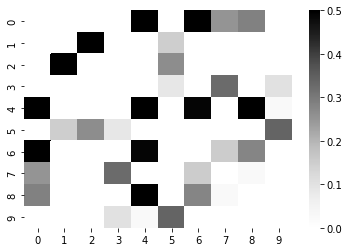

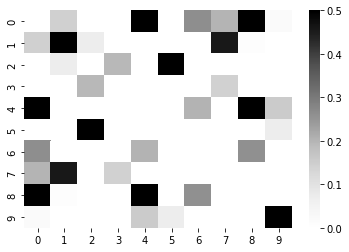

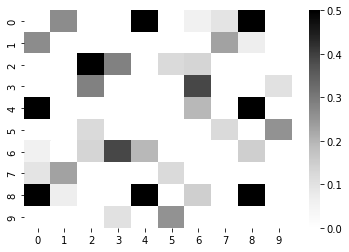

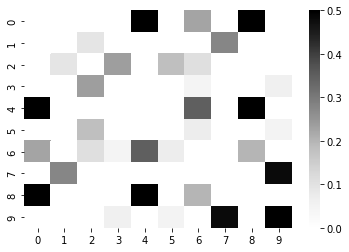

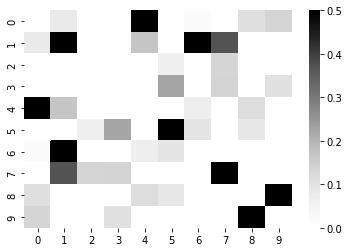

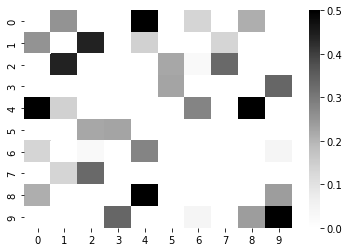

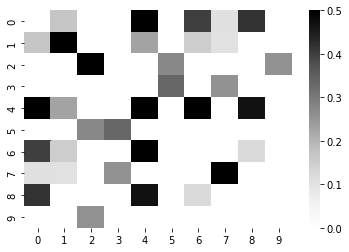

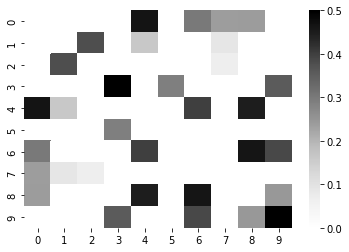

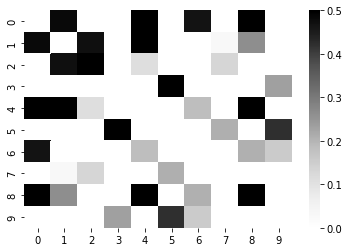

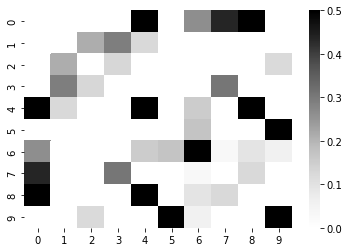

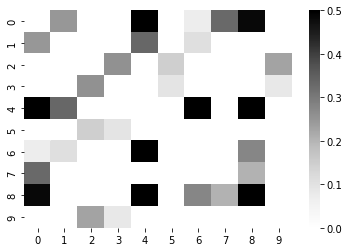

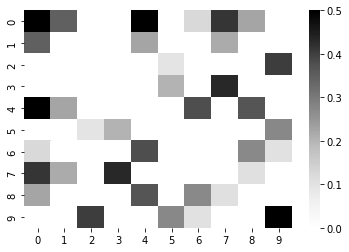

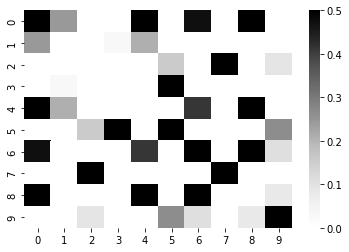

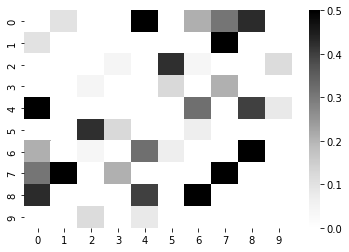

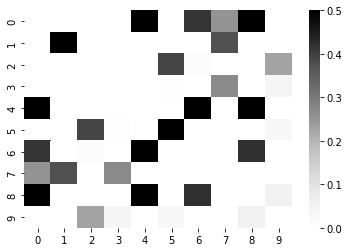

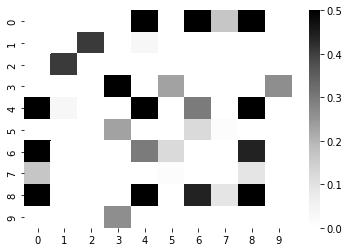

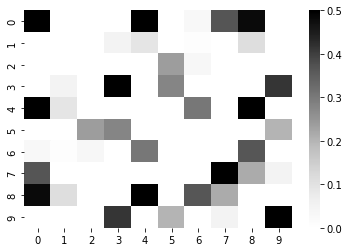

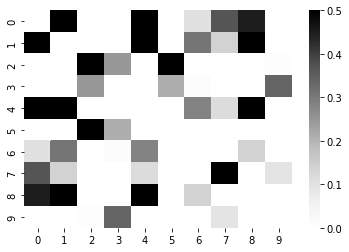

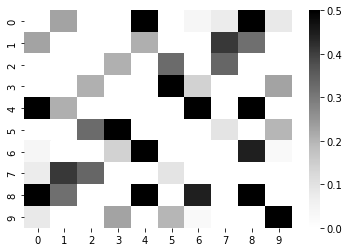

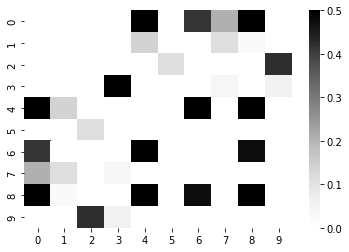

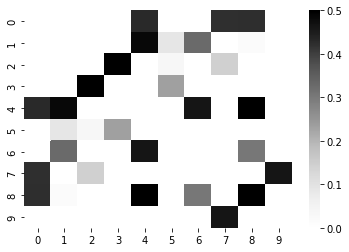

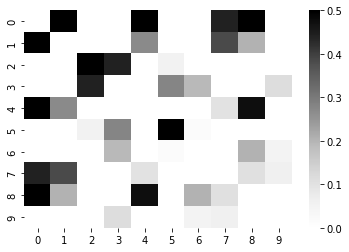

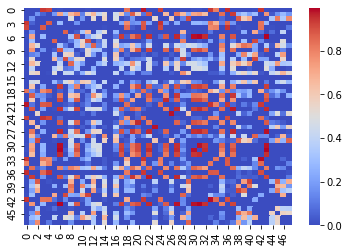

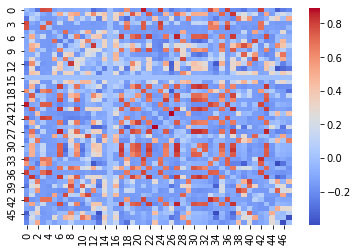

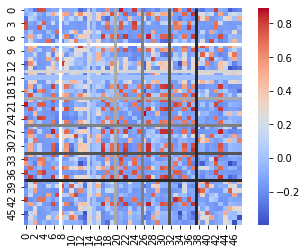

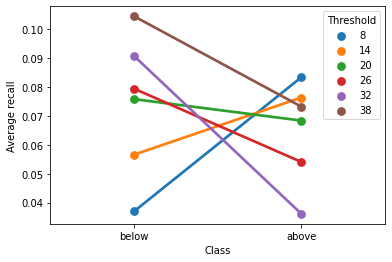

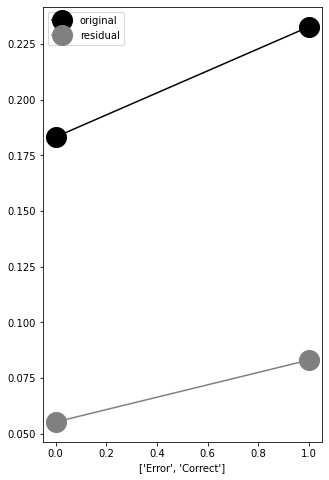

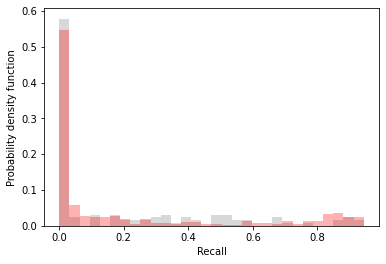

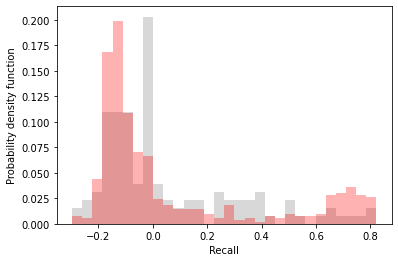

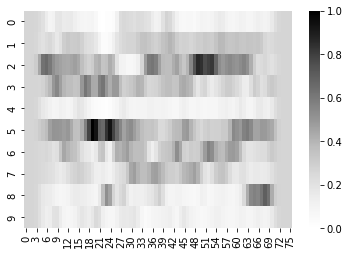

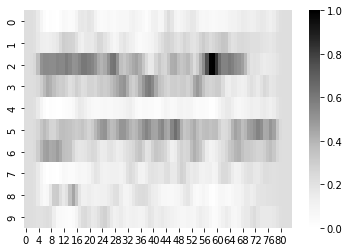

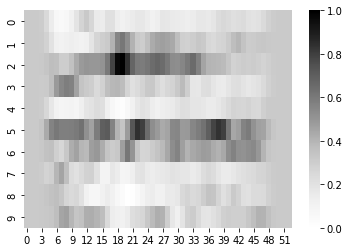

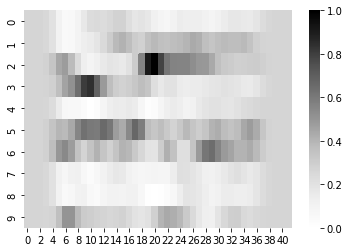

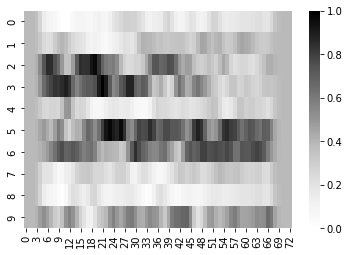

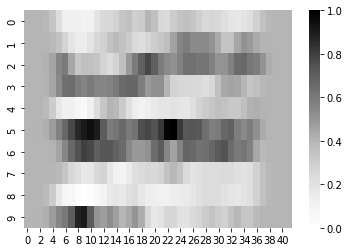

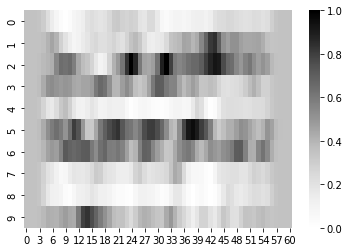

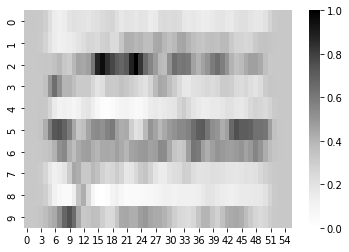

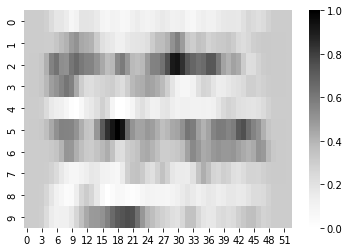

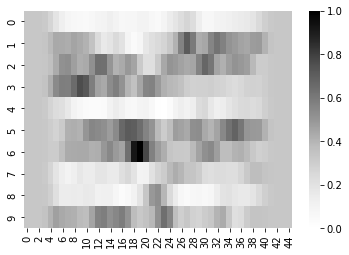

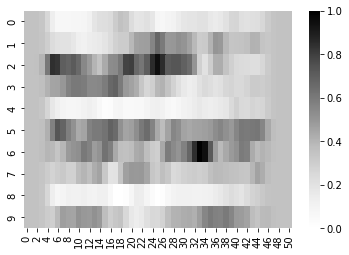

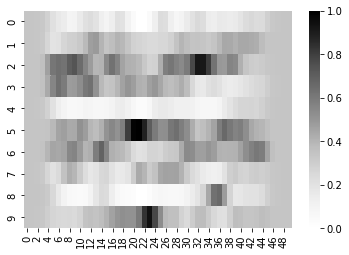

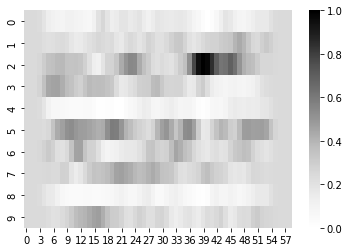

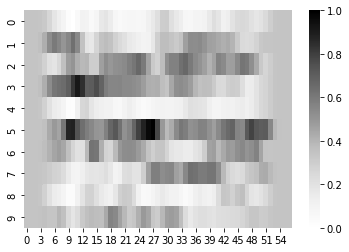

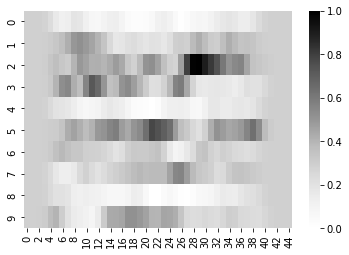

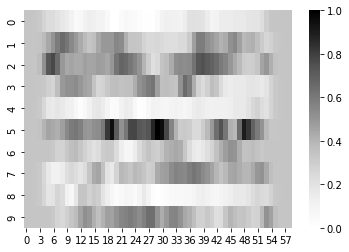

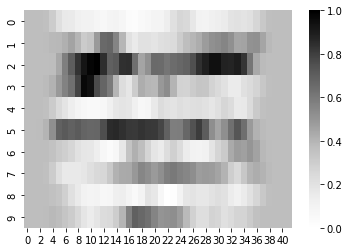

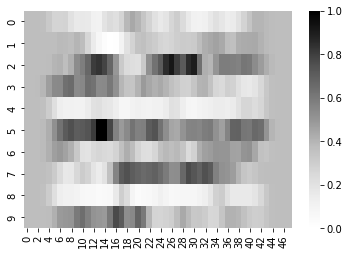

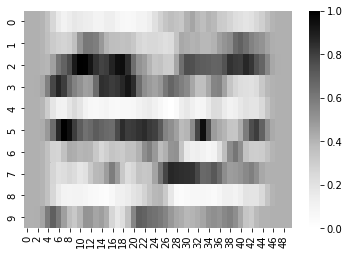

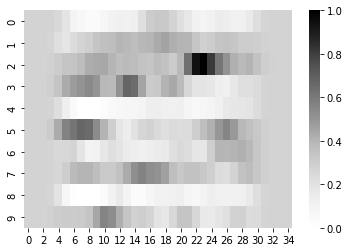

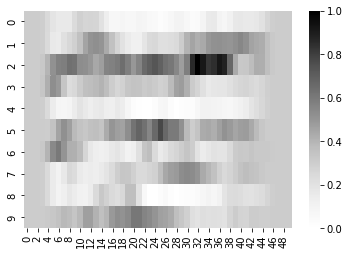

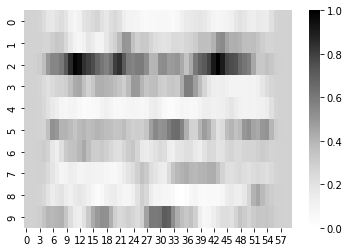

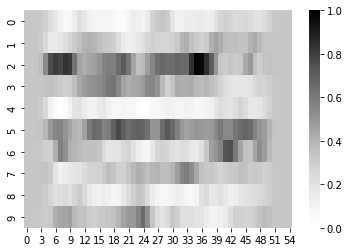

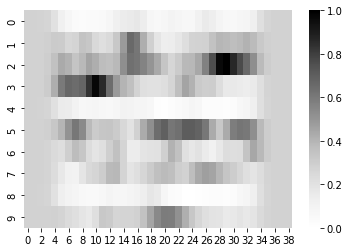

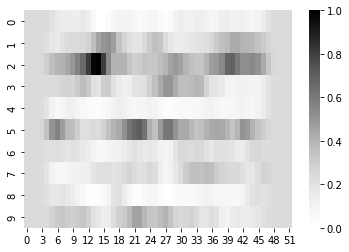

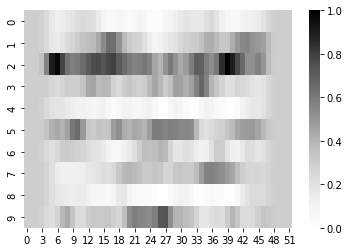

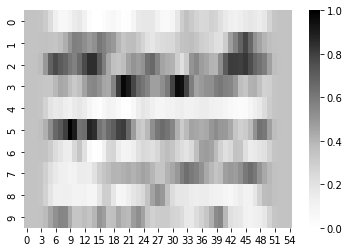

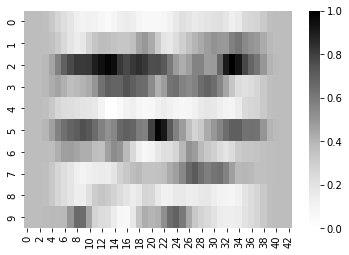

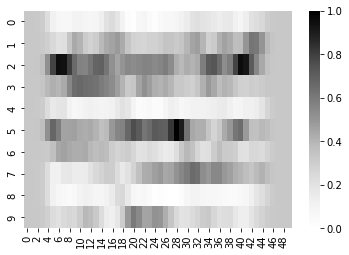

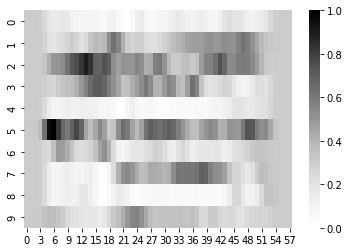

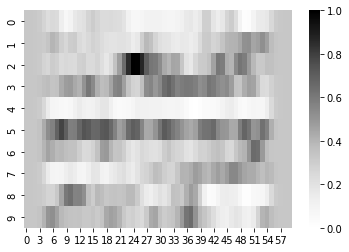

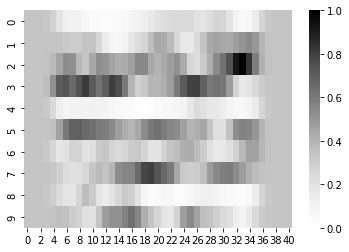

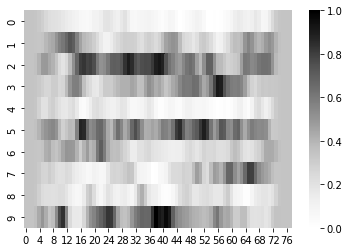

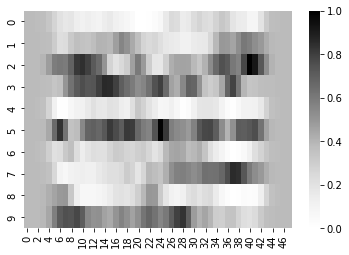

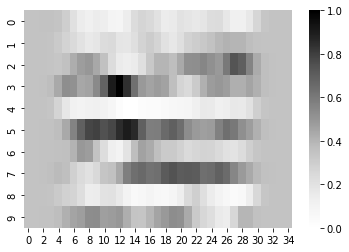

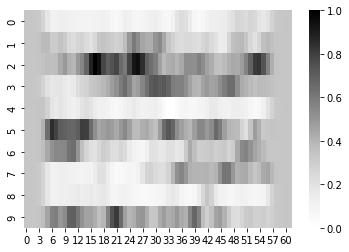

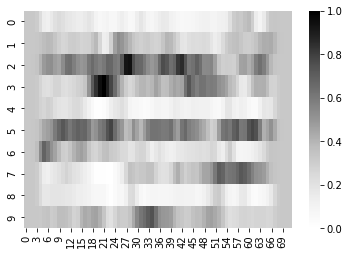

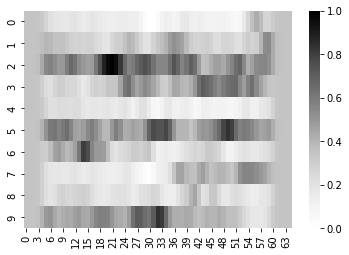

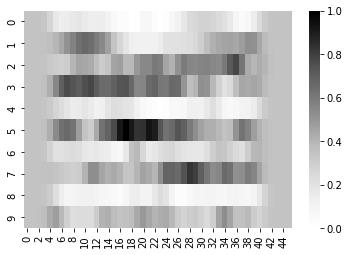

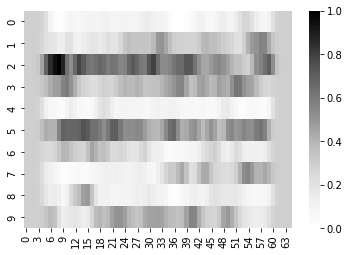

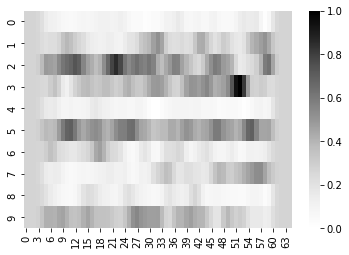

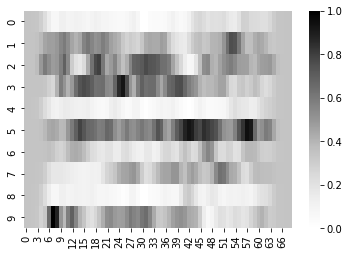

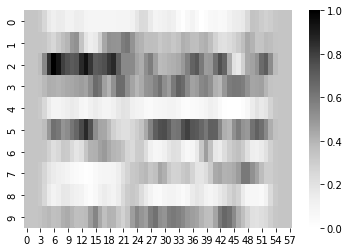

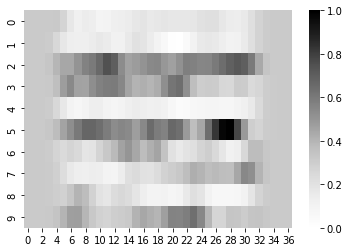

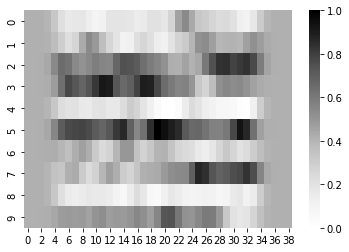

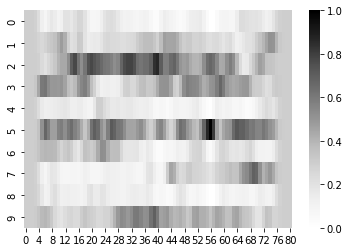

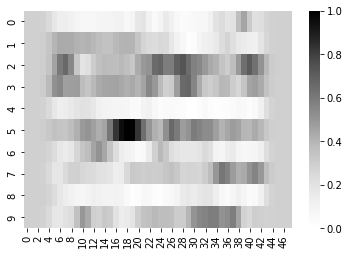

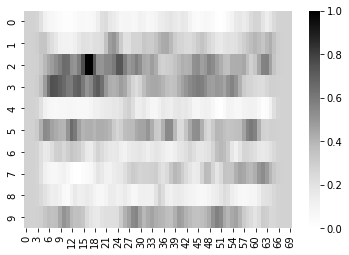

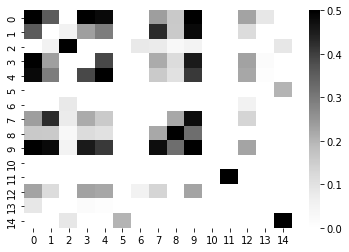

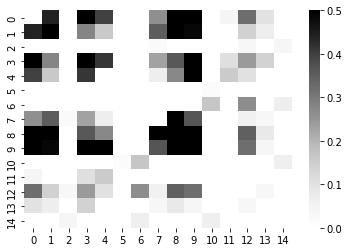

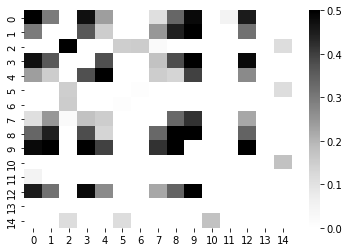

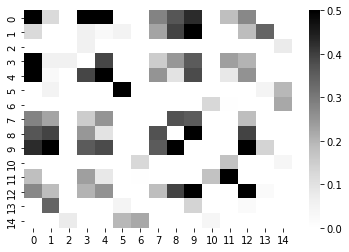

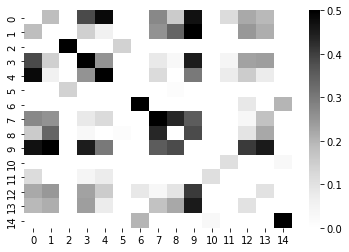

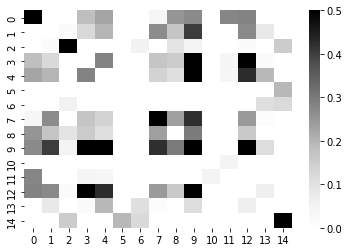

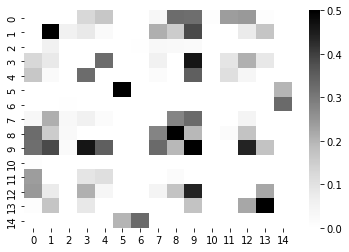

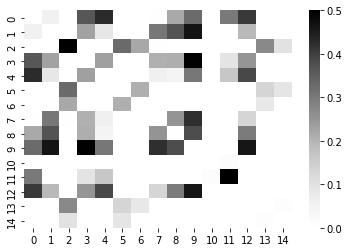

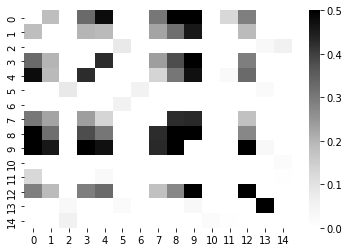

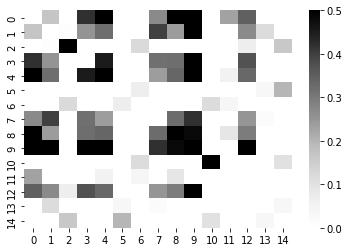

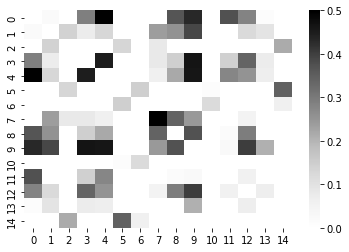

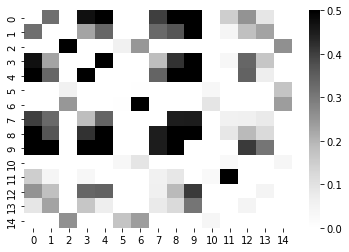

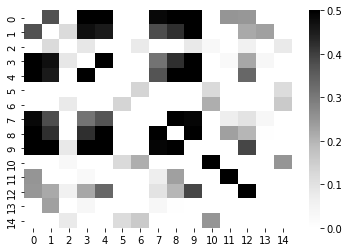

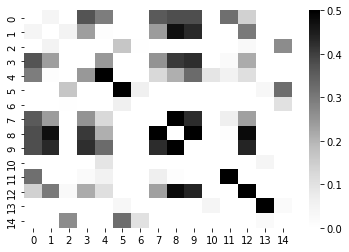

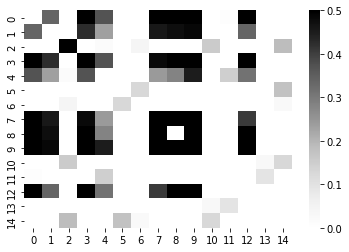

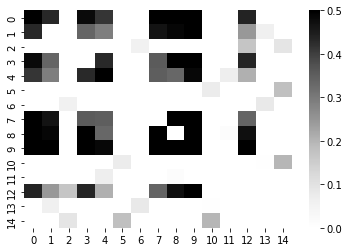

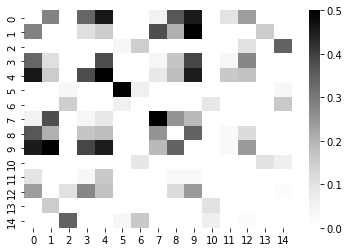

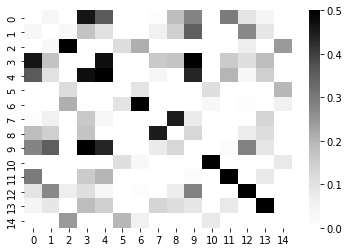

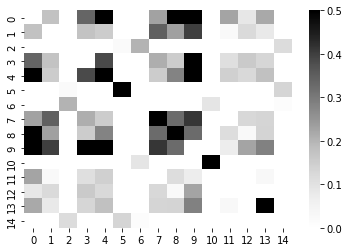

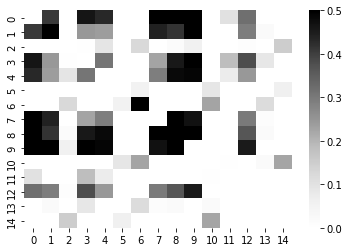

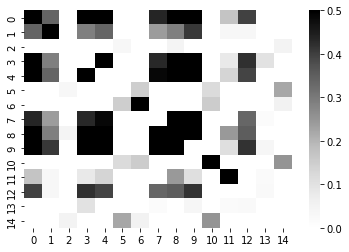

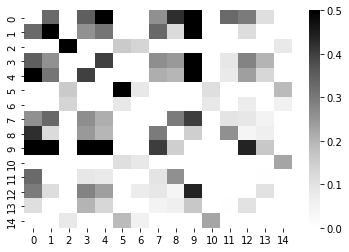

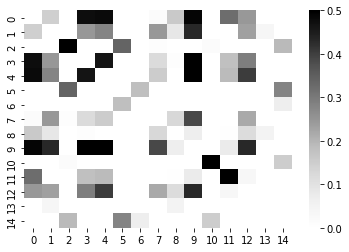

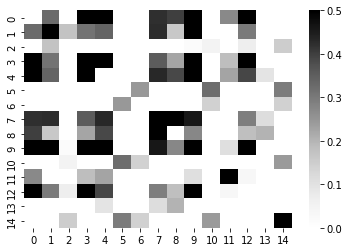

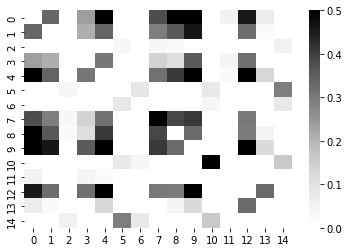

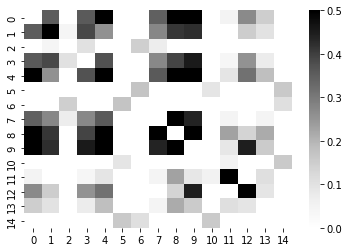

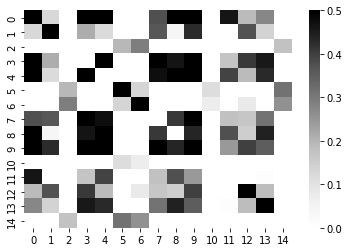

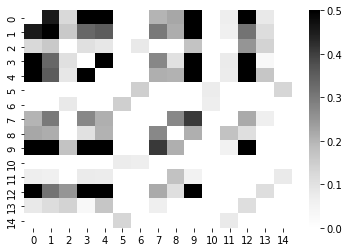

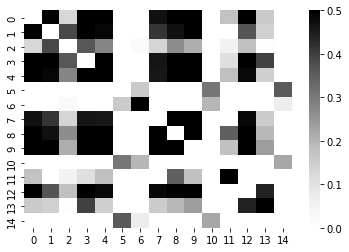

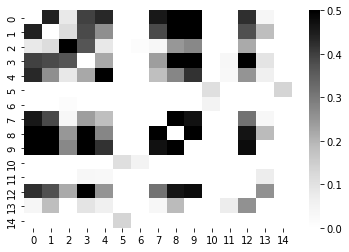

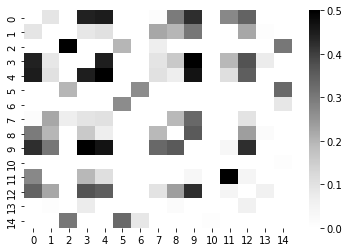

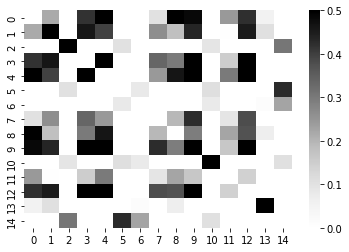

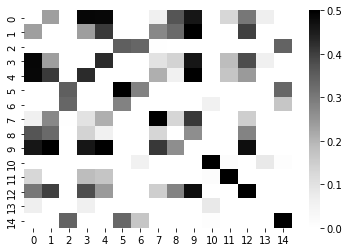

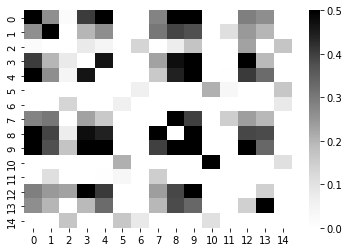

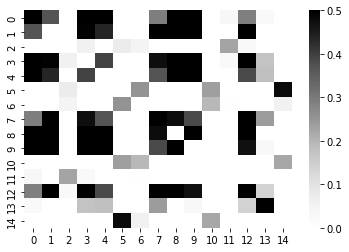

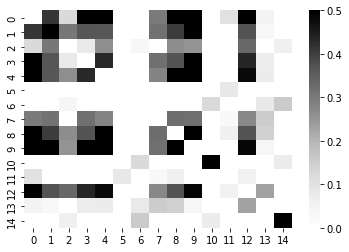

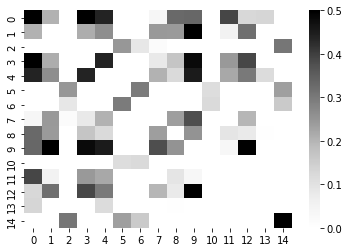

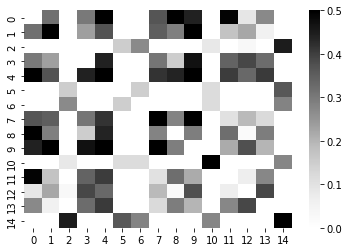

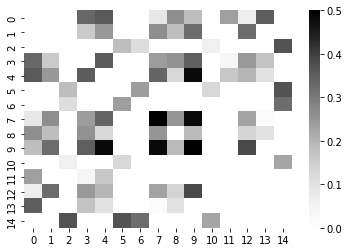

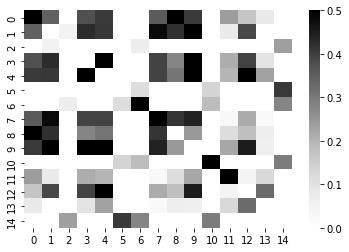

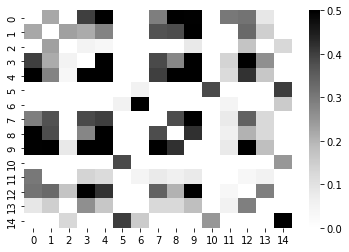

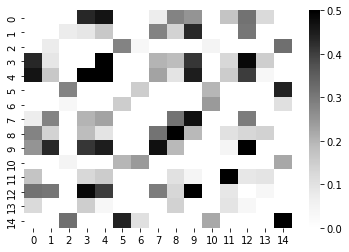

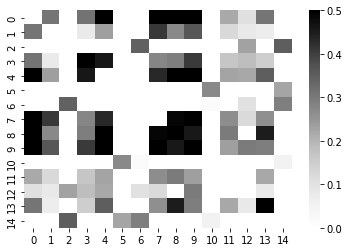

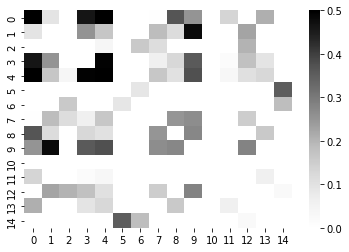

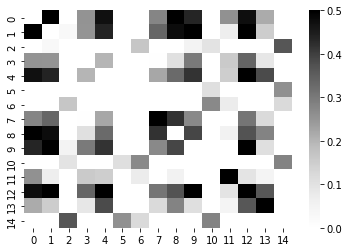

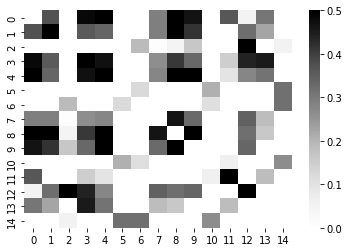

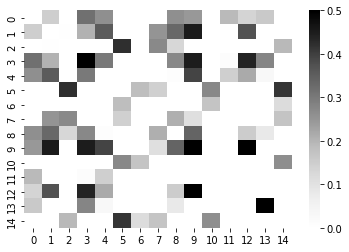

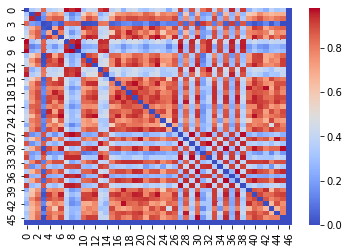

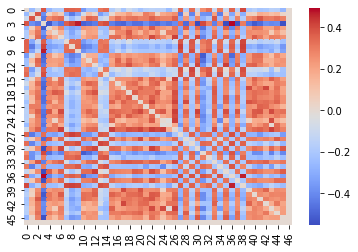

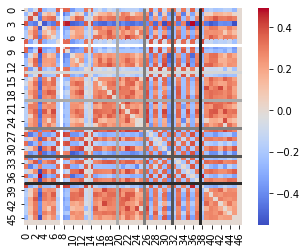

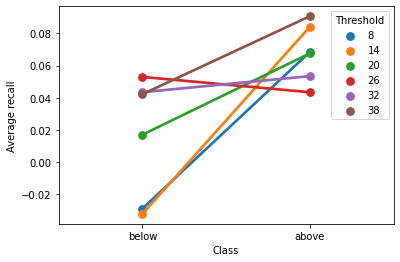

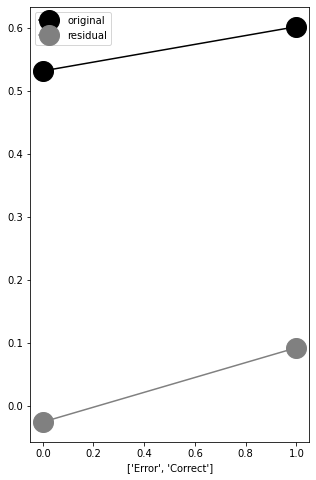

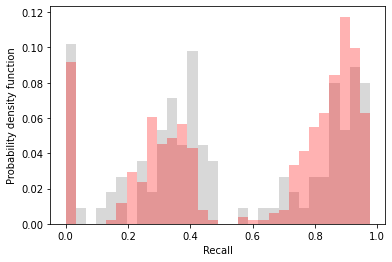

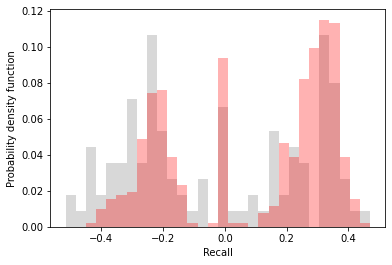

In [ ]:
# It takes about 20 minutes to run this code with number of shuffles = 1000
behaviour_dataset, firing_rates, similarity_matrices, recall_matrices, residual_matrices = run_session_analysis('201222', 1000, dir=dir, save_figs=False);

## **Resultados**

#### Fig. 1B

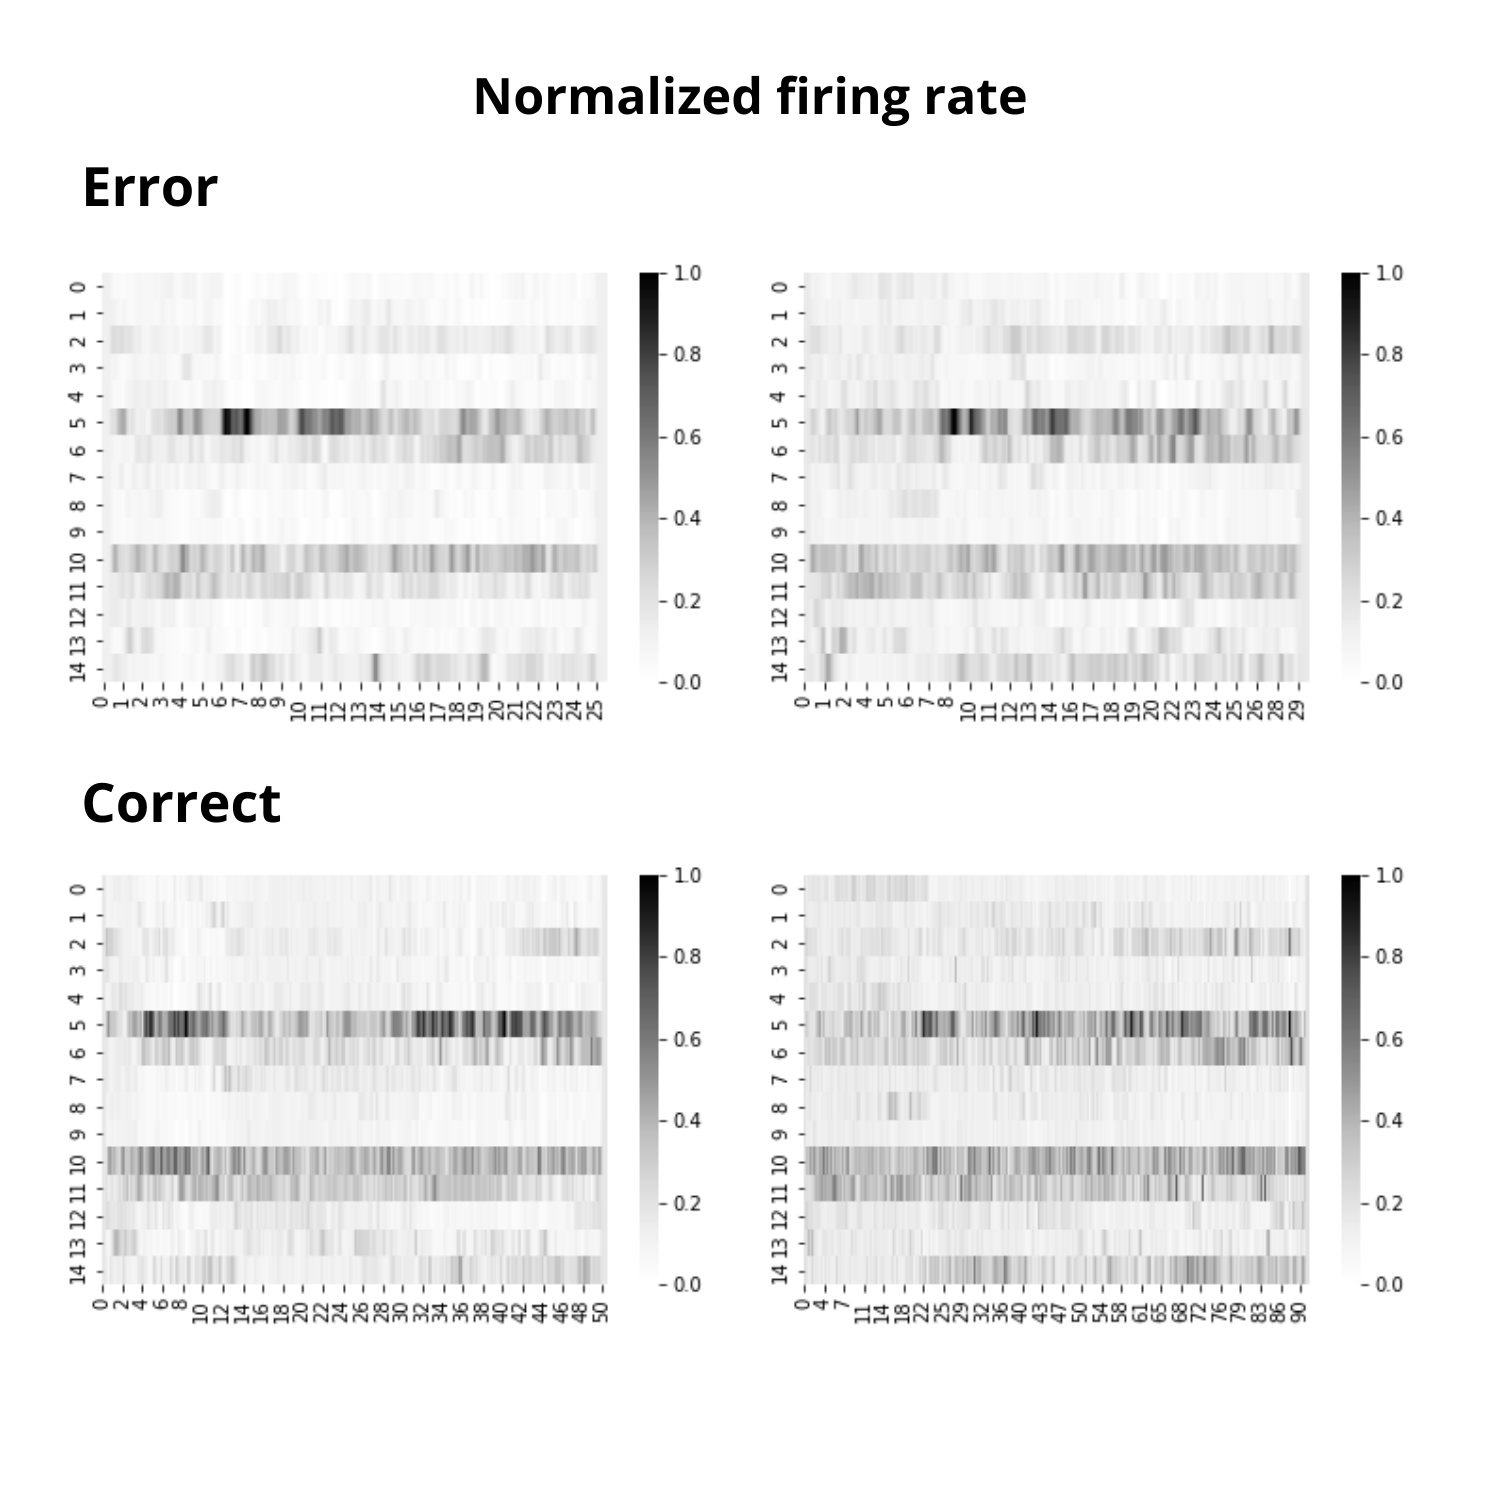

##### Fig. 2A

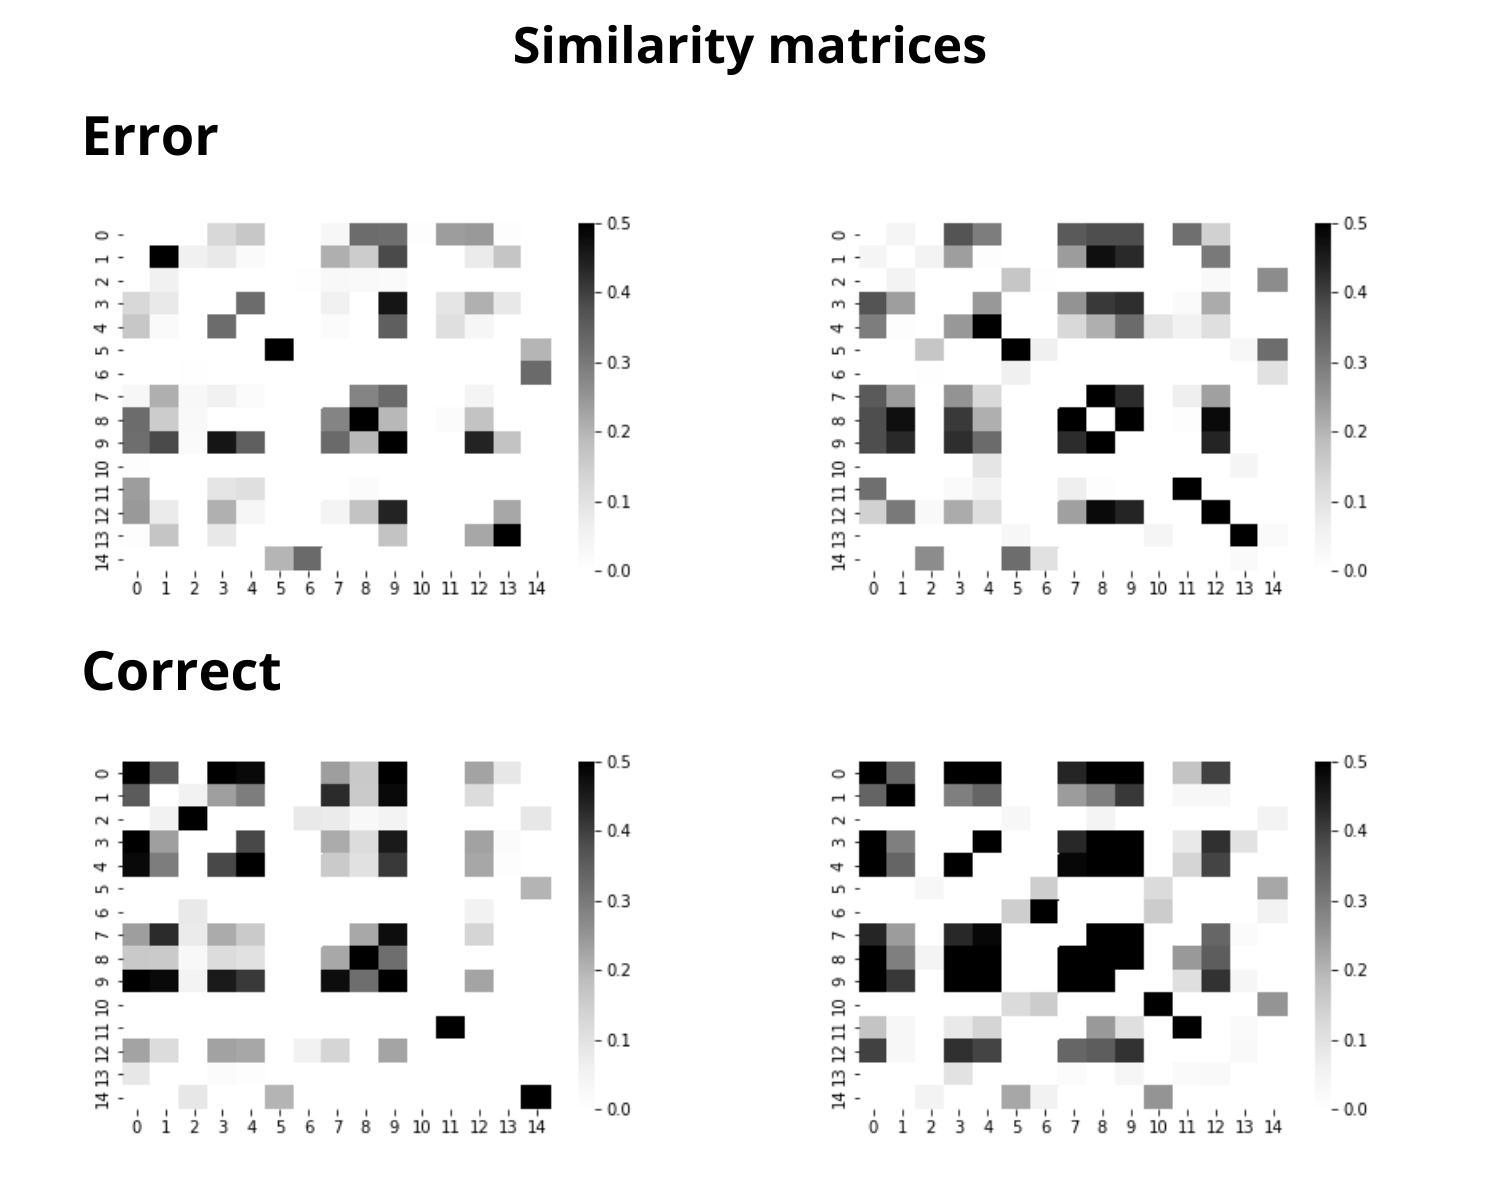

#### Fig. 2C

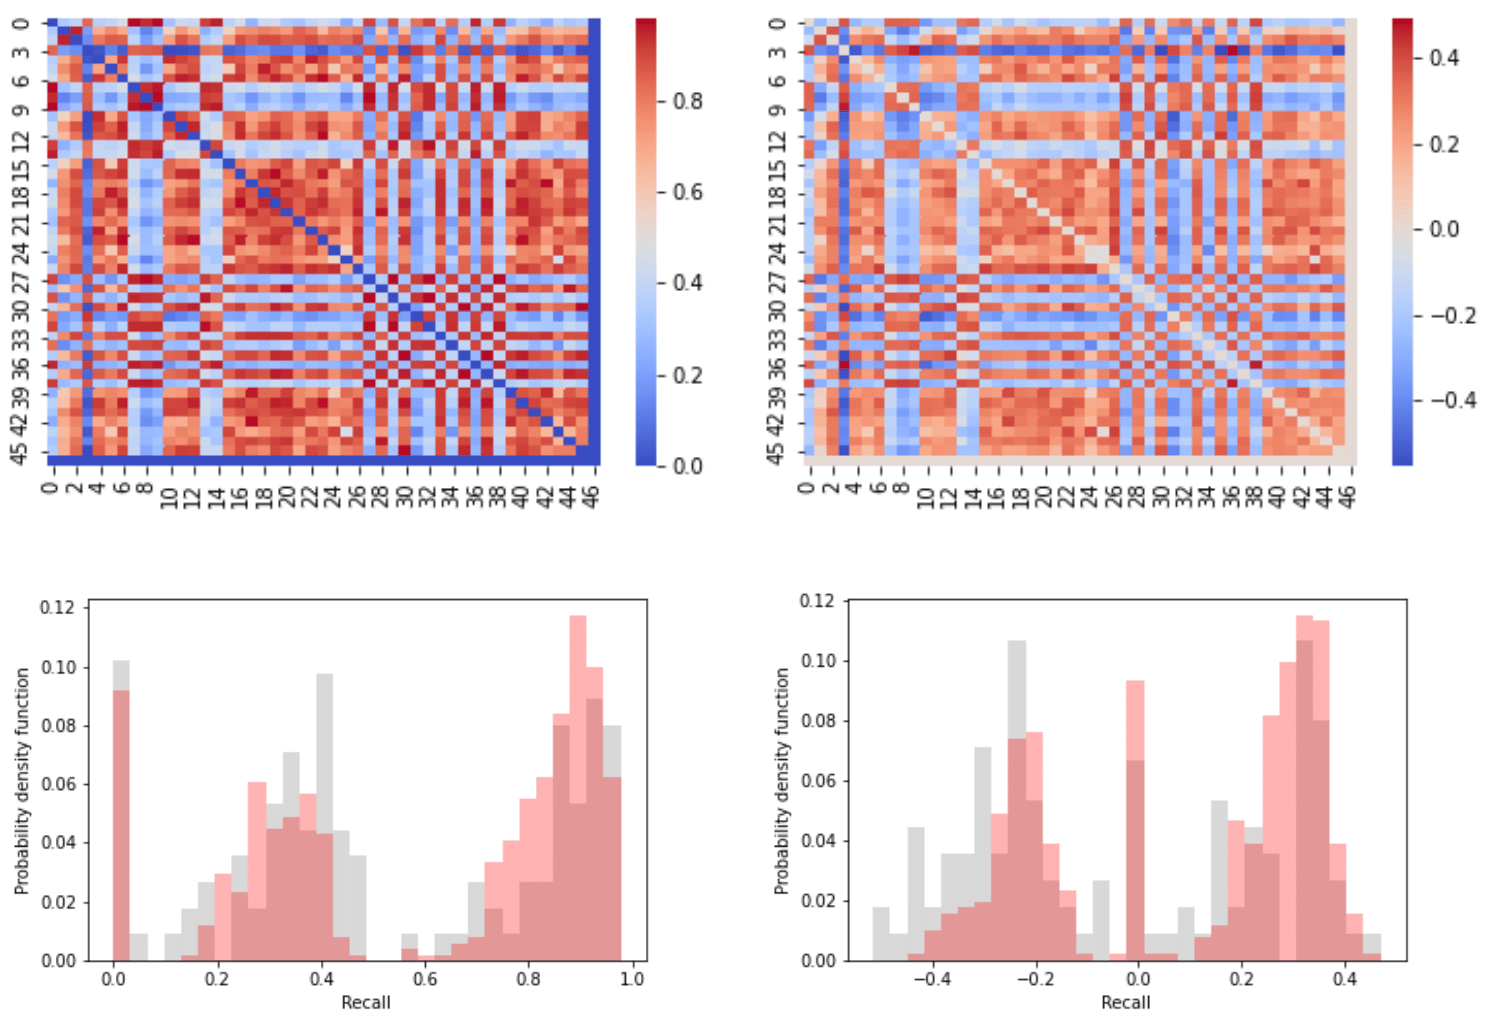

#### Fig. 2D

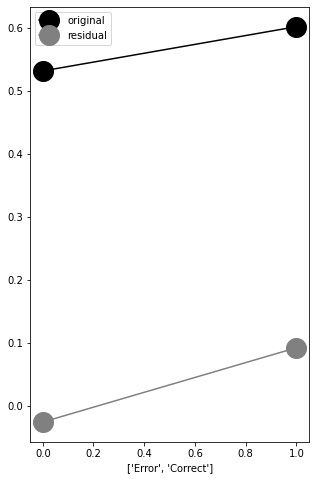

#### Fig. 4A

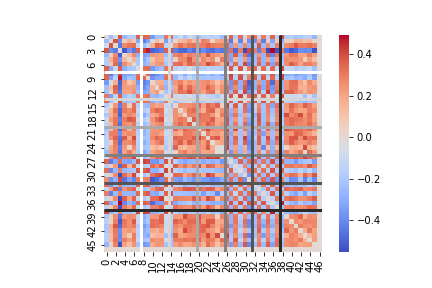

#### Fig. 4B

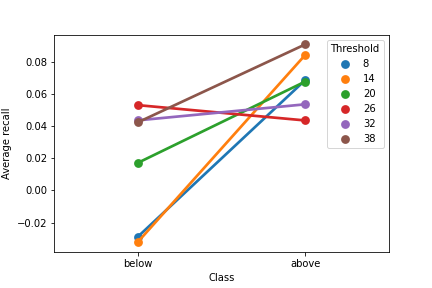

### **Conclusões:**

Por limitações de tempo e de hardware (o Google Colab limita a duração da sessão e os recursos de memória RAM e disco disponíveis) as análises que reproduzimos são pertinentes apenas a uma sessão, contemplando as figuras 1b, 2a-d e 4a-b.

Em uma inspeção visual, podemos concluir qualitativamente que o aspecto da convolução do trem de spikes com o filtro gaussiano e a construção das matrizes de similaridade são análogos àqueles apresentados no artigo original. As diferenças vêm de uma diferença óbvia: como no artigo original os autores não informam a qual trial e sessão essas figuras pertencem, tivemos que escolher quatro trials aleatórias na sessão que escolhemos (também ao acaso) pra apresentar.

Na figura 2, os autores dividiram a matriz de recordação (recall) em blocos contemplando todas as trials erradas e todas as trials corretas, depois de um reordenamento. Como apresentado na figura 2d, a recordação média (estimada pela média da matriz) é variável entre trials corretas e incorretas - mesmo quando subtraímos os efeitos da duração, olhando pra matriz de recordação residual.

Assim como no artigo original (Fig. 2C e 2D), é possível observar pela análise desses resultados que o padrão de co-atividade dos intervalos após tentativas corretas era mais similar que o padrão observado após tentativas incorretas (erros). Contudo, a qualidade do ordenamento por trials corretas/incorretas é muito inferior à da figura 2C do artigo original, onde há uma nítida diferença entre os blocos de trials corretas e incorretas.

Na Fig. 4A, os autores investigaram se havia uma trial a partir da qual a média de recordação mudava abruptamente. Para tanto, segmentaram a matriz de recall em vários pares de blocos, um cujas trials eram anteriores àquela testada e outro cujas trials eram posteriores a esta. Essa segmentação pode ser vislumbrada no primeiro painel da figura abaixo, onde cada linha em escala de cinza separa a matriz de recall em uma trial-limiar.

Na Fig. 4B, também mostramos que assim como no artigo original reproduzimos a variação na recordação média de acordo com o limiar adotado, e que a maior variação ocorre cedo, já na oitava trial.

Essas duas figuras e conclusão que extraímos delas fundamentam as demais análises apresentadas na figura 4, onde para cada sessão a learning trial (estimada através do critério comportamental) é comparada com a trial-limiar que produz a variação mais abrupta na recordação média.


### Epílogo

Dificuldades:
* Entender quais as etapas de processamento que os autores fizeram a partir do artigo: muita informação é ambígua ou pouco intuitiva, e às vezes só diante de um resultado absurdo percebíamos que não podia ser aquela primeira interpretação do texto o que eles fizeram
* Desvendar o código dos autores (em MATLAB): o código estava fragmentado e com partes faltantes, e algumas funções não estavam devidamente comentadas. Também haviam partes inconsistentes, como constantes que apareciam com diferentes valores ao longo do código (e.g. a largura das bins)
* Elaborar uma estrutura de dados e uma estratégia de processamento que adequasse os dados, fosse interpretável, reescalável e que utilizasse as melhores práticas (e.g. evitar loops com *for*, e isso relaciona-se com o ponto seguinte)
* Implementar boa parte das funções: começávamos com uma ideia ambiciosa (mais paralelismo, menos iteradores, funções mais genéricas; [pensando no princípio DRY (don't repeat yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) de programar) e descobríamos, em uma etapa posterior da análise, que aderir a esse padrão iria custar muito em tempo e oferecer obstáculos adiante, o que fazia com que voltássemos e tivéssemos que readequar as funções várias vezes
* Comparar com os resultados dos autores, uma vez que eles não informam a qual sessão/trial cada resultado pertence (e.g A qual sessão pertence a matriz de recordação na figura 2? Não sabemos.)
* A programação em pares num ambiente com o colab é por vezes problemática: dois usuários não podem acessar o mesmo arquivo simultaneamente (e se o fizerem, podem haver perdas das alterações feitas por um dos acessantes, como aconteceu conosco) e tínhamos que programar separadamente; às vezes modificávamos uma função e no código do outro, que estava implementando outra parte do projeto, constava uma versão antiga (e essas inconsistências causaram muita dor de cabeça)

O que nós gostamos da atividade:
* Trabalhar com os dados de outra pessoa tem um caráter investigativo que é, simultaneamente, frustrante e instigante; na parte instigante, quando descobríamos o que os autores *realmente* queriam dizer e o que eles haviam feito foi bastante interessante
* Poder trabalhar em conjunto, afinal temos uma sinergia bastante interessante e nos acertamos bem; conseguimos parcelar bem as tarefas e aprendemos bastante um com o outro
* Sobretudo a demanda por padronização do código (afinal, ele precisa ser inteligível para o outro, que constrói algo sobre aquilo) é benéfica pra ambos

O que aprendemos com ela:
* Bastante sobre Python: embora seja a nossa linguagem principal, ainda há muito a aprimorar e a melhor maneira é justamente se deparando com erros inesperados ou demandas que fogem ao escopo do nosso conhecimento prévio, como aconteceu nesse projeto
* E também sobre MATLAB: na tentativa de entender o que os autores haviam implementado, precisamos consultar a documentação e *debugar* fragmentos de código (no Octave) que serviam pra testar as nossas hipóteses, e encontrar jeitos de chegar à exata mesma resposta em Python
* A programar em dupla: porcionar as demandas de implementação pra que ambos possam trabalhar simultaneamente, comunicar os erros e as modificações que fez ao outro de maneira clara e compreensível
* Sobre dados de atividade de spiking e comportamento armazenados em um formato que não havíamos visto antes, e pensar em como explorar essa estrutura de forma ótima pra extrair o que precisávamos pra análise